In [11]:
# =====================================
# ENHANCED POLLUTION PREDICTION MODEL
# Focus: LightGBM, XGBoost, Random Forest
# Features: SHAP Analysis, Advanced Feature Engineering, Stacking Ensemble
# =====================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, KFold
from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.cluster import DBSCAN
import lightgbm as lgb
import xgboost as xgb
import optuna
from optuna.samplers import TPESampler
import shap
import warnings
import joblib
import os
from scipy import stats
from scipy.stats import boxcox, yeojohnson
import gc

warnings.filterwarnings('ignore')

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Enhanced Pollution Prediction Model - Three Core Models Focus")
print("=" * 80)

Enhanced Pollution Prediction Model - Three Core Models Focus


In [12]:
# =====================================
# ADVANCED FEATURE ENGINEERING V2
# =====================================

def create_advanced_features_v2(df, is_train=True):
    """
    Advanced feature engineering focusing on spatial, temporal, and interaction features
    """
    df_adv = df.copy()
    
    print(f"Creating advanced features v2... Initial shape: {df_adv.shape}")
    
    # Preserve target column if it exists (for training data)
    target_col = None
    if 'pollution_value' in df_adv.columns:
        target_col = df_adv['pollution_value'].copy()
        print("Pollution_value target column preserved for feature engineering")
    
    # First, handle any missing values in the dataframe
    print("Handling missing values...")
    initial_nan_count = df_adv.isnull().sum().sum()
    if initial_nan_count > 0:
        print(f"Found {initial_nan_count} NaN values, filling with appropriate values...")
        
        # Fill numerical columns with median (excluding pollution_value)
        numerical_cols = df_adv.select_dtypes(include=[np.number]).columns
        numerical_cols = [col for col in numerical_cols if col != 'pollution_value']
        for col in numerical_cols:
            if df_adv[col].isnull().any():
                df_adv[col].fillna(df_adv[col].median(), inplace=True)
        
        # Fill categorical columns with mode
        categorical_cols = df_adv.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if df_adv[col].isnull().any():
                df_adv[col].fillna(df_adv[col].mode()[0] if len(df_adv[col].mode()) > 0 else 'unknown', inplace=True)
    
    # 1. POLYNOMIAL INTERACTIONS of key features
    key_features = ['latitude', 'longitude', 'hour']
    # Check if these features exist and have no NaN values
    available_key_features = [f for f in key_features if f in df_adv.columns]
    
    if len(available_key_features) >= 2:
        print(f"Creating polynomial features from: {available_key_features}")
        
        # Ensure no NaN values in key features
        for feature in available_key_features:
            if df_adv[feature].isnull().any():
                df_adv[feature].fillna(df_adv[feature].median(), inplace=True)
        
        # Check for any infinite values
        for feature in available_key_features:
            df_adv[feature] = df_adv[feature].replace([np.inf, -np.inf], df_adv[feature].median())
        
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        poly_features = poly.fit_transform(df_adv[available_key_features])
        poly_feature_names = poly.get_feature_names_out(available_key_features)
        
        for i, name in enumerate(poly_feature_names):
            if name not in available_key_features:
                df_adv[f'poly_{name}'] = poly_features[:, i]
        
        print(f"Added {len(poly_feature_names) - len(available_key_features)} polynomial interaction features")
    else:
        print(f"Skipping polynomial features - only {len(available_key_features)} key features available")
    
    # 2. SPATIAL CLUSTERING
    if 'latitude' in df_adv.columns and 'longitude' in df_adv.columns:
        coords = df_adv[['latitude', 'longitude']].values
        
        # DBSCAN clustering
        dbscan = DBSCAN(eps=0.05, min_samples=20)
        clusters = dbscan.fit_predict(coords)
        df_adv['spatial_cluster'] = clusters
        
        # Distance to major cluster centers
        unique_clusters = np.unique(clusters[clusters != -1])
        for cluster_id in unique_clusters[:3]:
            cluster_points = coords[clusters == cluster_id]
            if len(cluster_points) > 0:
                cluster_center = np.mean(cluster_points, axis=0)
                distances = np.sqrt(np.sum((coords - cluster_center)**2, axis=1))
                df_adv[f'dist_cluster_{cluster_id}'] = distances
    
    # 3. ENHANCED CYCLICAL FEATURES
    time_features = {
        'hour': 24,
        'day_of_week': 7,
        'day_of_year': 365.25,
        'month': 12
    }
    
    for feature, period in time_features.items():
        if feature in df_adv.columns:
            # Multiple harmonics
            for harmonic in [1, 2, 3]:
                df_adv[f'{feature}_sin_h{harmonic}'] = np.sin(2 * np.pi * harmonic * df_adv[feature] / period)
                df_adv[f'{feature}_cos_h{harmonic}'] = np.cos(2 * np.pi * harmonic * df_adv[feature] / period)
    
    # 4. STATISTICAL AGGREGATIONS
    if 'latitude' in df_adv.columns and 'longitude' in df_adv.columns:
        # Spatial binning
        df_adv['lat_bin'] = pd.cut(df_adv['latitude'], bins=15, labels=False)
        df_adv['lon_bin'] = pd.cut(df_adv['longitude'], bins=15, labels=False)
        
        # Combined spatial bin
        df_adv['spatial_bin'] = df_adv['lat_bin'] * 100 + df_adv['lon_bin']
    
    # 5. DISTANCE-BASED FEATURES
    if 'latitude' in df_adv.columns and 'longitude' in df_adv.columns:
        lat_center = df_adv['latitude'].mean()
        lon_center = df_adv['longitude'].mean()
        
        df_adv['distance_from_center'] = np.sqrt(
            (df_adv['latitude'] - lat_center)**2 + 
            (df_adv['longitude'] - lon_center)**2
        )
        
        # Distance from boundaries
        df_adv['dist_from_lat_min'] = df_adv['latitude'] - df_adv['latitude'].min()
        df_adv['dist_from_lat_max'] = df_adv['latitude'].max() - df_adv['latitude']
        df_adv['dist_from_lon_min'] = df_adv['longitude'] - df_adv['longitude'].min()
        df_adv['dist_from_lon_max'] = df_adv['longitude'].max() - df_adv['longitude']
    
    # 6. TEMPORAL PATTERNS
    if 'hour' in df_adv.columns:
        # Rush hour indicators
        df_adv['is_morning_rush'] = ((df_adv['hour'] >= 7) & (df_adv['hour'] <= 9)).astype(int)
        df_adv['is_evening_rush'] = ((df_adv['hour'] >= 17) & (df_adv['hour'] <= 19)).astype(int)
        df_adv['is_rush_hour'] = (df_adv['is_morning_rush'] | df_adv['is_evening_rush']).astype(int)
        
        # Time of day categories
        df_adv['time_category'] = pd.cut(df_adv['hour'], 
                                        bins=[0, 6, 12, 18, 24], 
                                        labels=['night', 'morning', 'afternoon', 'evening'],
                                        include_lowest=True)
        df_adv['time_category_encoded'] = pd.Categorical(df_adv['time_category']).codes
    
    if 'day_of_week' in df_adv.columns:
        df_adv['is_weekend'] = (df_adv['day_of_week'] >= 5).astype(int)
        
        if 'hour' in df_adv.columns:
            df_adv['weekend_hour_interaction'] = df_adv['is_weekend'] * df_adv['hour']
    
    # 7. WEATHER PROXY FEATURES
    if all(col in df_adv.columns for col in ['latitude', 'longitude', 'day_of_year']):
        # Simple weather proxies
        df_adv['weather_proxy'] = (
            np.sin(2*np.pi*df_adv['day_of_year']/365) * df_adv['latitude'] + 
            np.cos(2*np.pi*df_adv['day_of_year']/365) * df_adv['longitude']
        )
        
        # Temperature proxy
        df_adv['temp_proxy'] = (
            20 + 15 * np.sin(2*np.pi*(df_adv['day_of_year']-80)/365) +
            5 * np.sin(2*np.pi*df_adv['hour']/24) -
            0.1 * np.abs(df_adv['latitude'])
        )
    
    # 8. INTERACTION FEATURES
    numeric_cols = df_adv.select_dtypes(include=[np.number]).columns
    important_pairs = [
        ('latitude', 'longitude'),
        ('latitude', 'hour'),
        ('longitude', 'hour')
    ]
    
    for col1, col2 in important_pairs:
        if col1 in numeric_cols and col2 in numeric_cols:
            df_adv[f'{col1}_{col2}_interaction'] = df_adv[col1] * df_adv[col2]
            df_adv[f'{col1}_{col2}_ratio'] = df_adv[col1] / (df_adv[col2] + 1e-8)
    
    # 9. STATISTICAL FEATURES
    if len(numeric_cols) > 3:
        # Create some statistical aggregations across features
        df_adv['feature_mean'] = df_adv[numeric_cols[:5]].mean(axis=1)
        df_adv['feature_std'] = df_adv[numeric_cols[:5]].std(axis=1)
        df_adv['feature_median'] = df_adv[numeric_cols[:5]].median(axis=1)
    
    # Clean up categorical columns that can't be used directly
    df_adv = df_adv.drop(columns=['time_category'], errors='ignore')
    
    # Comprehensive NaN and infinite value handling
    print("Final cleanup: handling NaN and infinite values...")
    
    # Count initial problems
    initial_nan = df_adv.isnull().sum().sum()
    initial_inf = np.isinf(df_adv.select_dtypes(include=[np.number])).sum().sum()
    
    if initial_nan > 0:
        print(f"Cleaning {initial_nan} NaN values...")
        # Fill NaN with appropriate values
        numeric_columns = df_adv.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if df_adv[col].isnull().any():
                # Use median for numeric columns
                median_val = df_adv[col].median()
                if pd.isna(median_val):
                    df_adv[col].fillna(0, inplace=True)
                else:
                    df_adv[col].fillna(median_val, inplace=True)
        
        # Fill any remaining NaN with 0
        df_adv = df_adv.fillna(0)
    
    if initial_inf > 0:
        print(f"Cleaning {initial_inf} infinite values...")
        # Replace infinite values
        numeric_columns = df_adv.select_dtypes(include=[np.number]).columns
        for col in numeric_columns:
            if np.isinf(df_adv[col]).any():
                # Replace inf with column median, or 0 if median is also inf/nan
                median_val = df_adv[col].replace([np.inf, -np.inf], np.nan).median()
                if pd.isna(median_val):
                    df_adv[col] = df_adv[col].replace([np.inf, -np.inf], 0)
                else:
                    df_adv[col] = df_adv[col].replace([np.inf, -np.inf], median_val)
    
    # Final verification
    final_nan = df_adv.isnull().sum().sum()
    final_inf = np.isinf(df_adv.select_dtypes(include=[np.number])).sum().sum()
    
    if final_nan > 0 or final_inf > 0:
        print(f"Warning: Still have {final_nan} NaN and {final_inf} infinite values")
        # Last resort: fill everything with 0
        df_adv = df_adv.fillna(0)
        numeric_columns = df_adv.select_dtypes(include=[np.number]).columns
        df_adv[numeric_columns] = df_adv[numeric_columns].replace([np.inf, -np.inf], 0)
    
    # Restore target column if it was preserved
    if target_col is not None:
        df_adv['pollution_value'] = target_col
        print("Pollution_value target column restored after feature engineering")
    
    print(f"Advanced features v2 completed. Final shape: {df_adv.shape}")
    print(f"Added {df_adv.shape[1] - df.shape[1]} new features")
    print(f"Data quality: {df_adv.isnull().sum().sum()} NaN, {np.isinf(df_adv.select_dtypes(include=[np.number])).sum().sum()} infinite values")
    
    return df_adv

# Load and enhance data
print("Loading and enhancing training data...")
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Original train shape: {train_df.shape}")
print(f"Original test shape: {test_df.shape}")

# Data quality check
print("\nData Quality Check:")
print(f"Train NaN values: {train_df.isnull().sum().sum()}")
print(f"Test NaN values: {test_df.isnull().sum().sum()}")

# Check for infinite values in numeric columns
train_numeric = train_df.select_dtypes(include=[np.number])
test_numeric = test_df.select_dtypes(include=[np.number])
print(f"Train infinite values: {np.isinf(train_numeric).sum().sum()}")
print(f"Test infinite values: {np.isinf(test_numeric).sum().sum()}")

# Show columns with missing values
train_missing = train_df.isnull().sum()
test_missing = test_df.isnull().sum()
if train_missing.sum() > 0:
    print("Train columns with missing values:")
    print(train_missing[train_missing > 0])
if test_missing.sum() > 0:
    print("Test columns with missing values:")
    print(test_missing[test_missing > 0])

# Apply advanced feature engineering
train_enhanced = create_advanced_features_v2(train_df, is_train=True)
test_enhanced = create_advanced_features_v2(test_df, is_train=False)

print(f"Enhanced train shape: {train_enhanced.shape}")
print(f"Enhanced test shape: {test_enhanced.shape}")

# Post-feature engineering data quality check
print("\nPost-Feature Engineering Quality Check:")

# Check if target column exists
print(f"Columns in train_enhanced: {list(train_enhanced.columns)}")
print(f"Columns in test_enhanced: {list(test_enhanced.columns)}")

if 'pollution_value' not in train_enhanced.columns:
    print("ERROR: pollution_value column missing from train_enhanced!")
    print("Available columns:", train_enhanced.columns.tolist())
    
    # Try to restore target from original data
    if 'train_df' in locals() and 'pollution_value' in train_df.columns:
        print("Restoring pollution_value column from original training data...")
        train_enhanced['pollution_value'] = train_df['pollution_value']
        print("Pollution_value column successfully restored!")
    else:
        raise KeyError("pollution_value column missing and cannot be restored from original data")

print(f"Train enhanced NaN values: {train_enhanced.isnull().sum().sum()}")
print(f"Test enhanced NaN values: {test_enhanced.isnull().sum().sum()}")

train_enhanced_numeric = train_enhanced.select_dtypes(include=[np.number])
test_enhanced_numeric = test_enhanced.select_dtypes(include=[np.number])
print(f"Train enhanced infinite values: {np.isinf(train_enhanced_numeric).sum().sum()}")
print(f"Test enhanced infinite values: {np.isinf(test_enhanced_numeric).sum().sum()}")

# Align features between train and test
train_features = set(train_enhanced.columns) - {'pollution_value'}
test_features = set(test_enhanced.columns) - {'id'}
common_features = list(train_features.intersection(test_features))

print(f"Common features: {len(common_features)}")

# Prepare final datasets
X = train_enhanced[common_features]
y = train_enhanced['pollution_value']
X_test = test_enhanced[common_features]
test_ids = test_enhanced['id']

# Final data quality check on X and X_test
print(f"\nFinal Dataset Quality Check:")
print(f"X NaN values: {X.isnull().sum().sum()}")
print(f"X_test NaN values: {X_test.isnull().sum().sum()}")
print(f"X infinite values: {np.isinf(X).sum().sum()}")
print(f"X_test infinite values: {np.isinf(X_test).sum().sum()}")

# If there are still issues, fix them
if X.isnull().sum().sum() > 0 or X_test.isnull().sum().sum() > 0:
    print("Fixing remaining NaN values...")
    X = X.fillna(0)
    X_test = X_test.fillna(0)

if np.isinf(X).sum().sum() > 0 or np.isinf(X_test).sum().sum() > 0:
    print("Fixing remaining infinite values...")
    X = X.replace([np.inf, -np.inf], 0)
    X_test = X_test.replace([np.inf, -np.inf], 0)

print(f"Final X shape: {X.shape}")
print(f"Final X_test shape: {X_test.shape}")
print("Advanced feature engineering completed!")

Loading and enhancing training data...
Original train shape: (7649, 8)
Original test shape: (2739, 7)

Data Quality Check:
Train NaN values: 26
Test NaN values: 0
Train infinite values: 0
Test infinite values: 0
Train columns with missing values:
latitude     13
longitude    13
dtype: int64
Creating advanced features v2... Initial shape: (7649, 8)
Pollution_value target column preserved for feature engineering
Handling missing values...
Found 26 NaN values, filling with appropriate values...
Creating polynomial features from: ['latitude', 'longitude', 'hour']
Added 3 polynomial interaction features
Final cleanup: handling NaN and infinite values...
Pollution_value target column restored after feature engineering
Advanced features v2 completed. Final shape: (7649, 64)
Added 56 new features
Data quality: 0 NaN, 0 infinite values
Creating advanced features v2... Initial shape: (2739, 7)
Handling missing values...
Creating polynomial features from: ['latitude', 'longitude', 'hour']
Added 3

Applying target transformation and enhanced preprocessing...
Original target statistics:
  Mean: 22.8132
  Std: 46.6506
  Skewness: 13.5714
  Min: 3.5000, Max: 1352.8000
Box-Cox lambda: -0.3495
Yeo-Johnson transformation applied

Original target statistics:
  Mean: 22.8132
  Std: 46.6506
  Skewness: 13.5714
  Min: 3.5000, Max: 1352.8000
Box-Cox lambda: -0.3495
Yeo-Johnson transformation applied


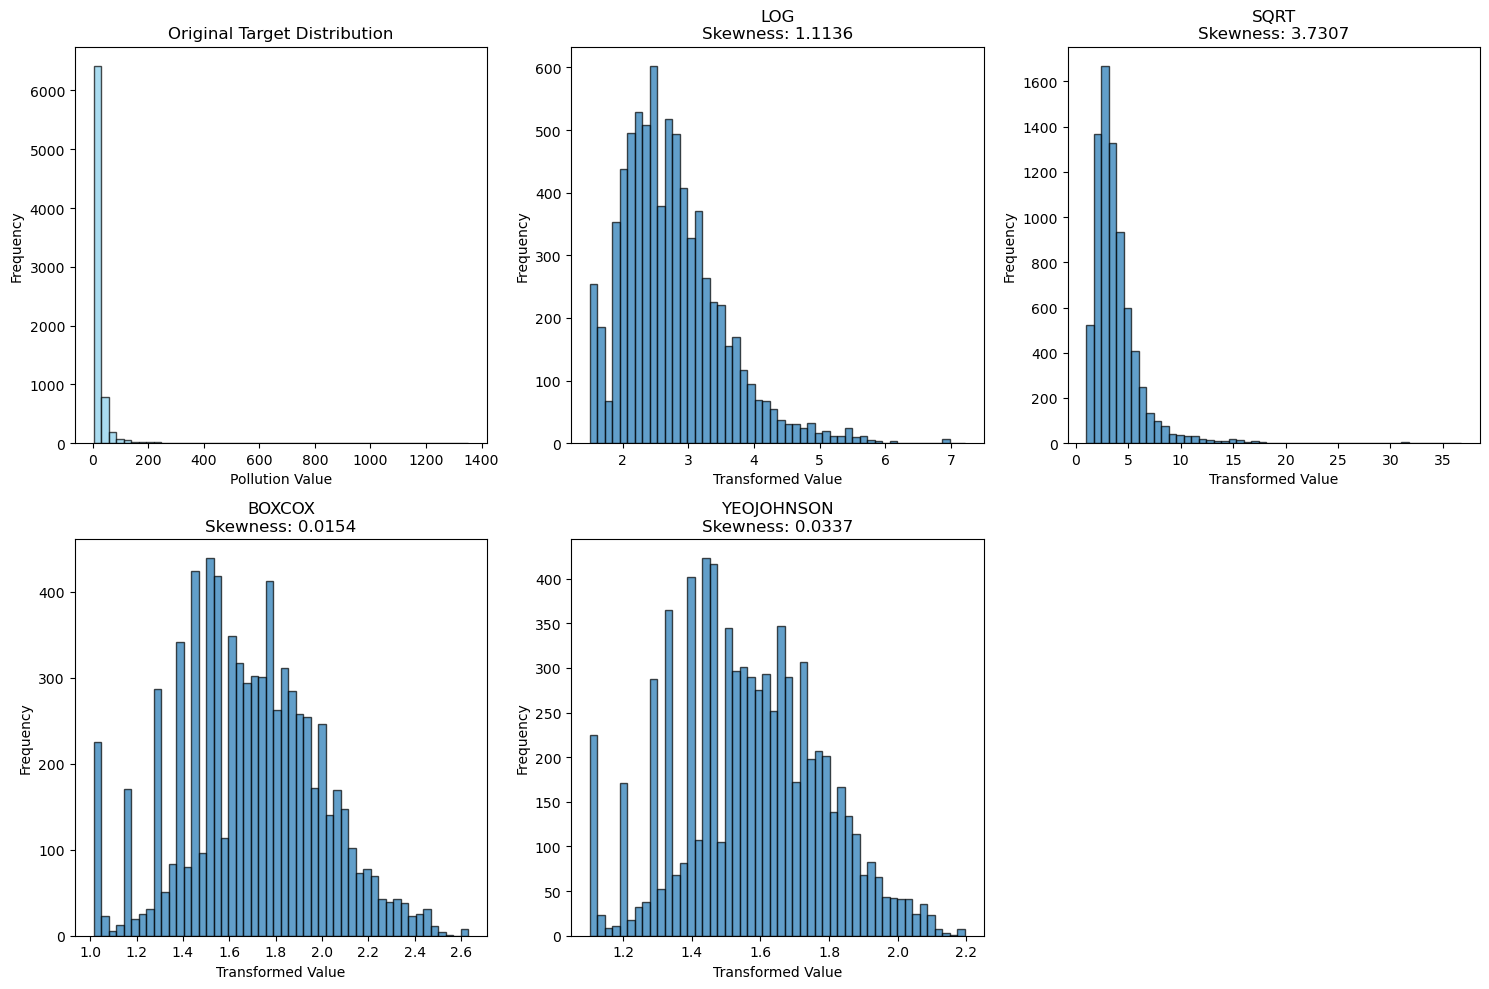


Best transformation: boxcox (skewness: 0.0154)
Target transformation applied: boxcox
Transformed target statistics:
  Mean: 1.6929
  Std: 0.3000
  Skewness: 0.0154

Advanced outlier detection and treatment...
  Outliers detected and treated: 15102
  Top features with outliers: [('hour_cos_h3', 3165), ('latitude_hour_ratio', 1587), ('day_of_year_cos_h3', 1173), ('is_rush_hour', 1114), ('longitude_hour_ratio', 1109)]
Data cleaning completed. Final dataset shape: (7649, 59)
Final target distribution - Mean: 1.6929, Std: 0.3000


In [13]:
# =====================================
# TARGET TRANSFORMATION & ENHANCED PREPROCESSING
# =====================================

print("Applying target transformation and enhanced preprocessing...")
print("=" * 80)

# Analyze target distribution
plt.figure(figsize=(15, 10))

# Original target distribution
plt.subplot(2, 3, 1)
plt.hist(y, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Original Target Distribution')
plt.xlabel('Pollution Value')
plt.ylabel('Frequency')

# Target statistics
print(f"Original target statistics:")
print(f"  Mean: {y.mean():.4f}")
print(f"  Std: {y.std():.4f}")
print(f"  Skewness: {y.skew():.4f}")
print(f"  Min: {y.min():.4f}, Max: {y.max():.4f}")

# Test different transformations
transformations = {
    'log': np.log1p(y),
    'sqrt': np.sqrt(y - y.min() + 1),
    'boxcox': None,
    'yeojohnson': None
}

# Box-Cox transformation (requires positive values)
if (y > 0).all():
    y_positive = y
else:
    y_positive = y - y.min() + 1

try:
    y_boxcox, lambda_boxcox = boxcox(y_positive)
    transformations['boxcox'] = y_boxcox
    print(f"Box-Cox lambda: {lambda_boxcox:.4f}")
except:
    print("Box-Cox transformation failed")

# Yeo-Johnson transformation (handles negative values)
try:
    transformer_yj = PowerTransformer(method='yeo-johnson', standardize=False)
    y_yeojohnson = transformer_yj.fit_transform(y.values.reshape(-1, 1)).flatten()
    transformations['yeojohnson'] = y_yeojohnson
    print("Yeo-Johnson transformation applied")
except:
    print("Yeo-Johnson transformation failed")

# Evaluate transformations by skewness reduction
skewness_results = {}
for name, transformed_y in transformations.items():
    if transformed_y is not None:
        skew = pd.Series(transformed_y).skew()
        skewness_results[name] = abs(skew)
        
        # Plot distribution
        plt.subplot(2, 3, list(transformations.keys()).index(name) + 2)
        plt.hist(transformed_y, bins=50, alpha=0.7, edgecolor='black')
        plt.title(f'{name.upper()}\nSkewness: {skew:.4f}')
        plt.xlabel('Transformed Value')
        plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig('plots/target_transformations.png', dpi=300, bbox_inches='tight')
plt.show()

# Select best transformation (lowest absolute skewness)
best_transform = min(skewness_results, key=skewness_results.get)
best_skewness = skewness_results[best_transform]

print(f"\nBest transformation: {best_transform} (skewness: {best_skewness:.4f})")

# Apply the best transformation
if best_transform == 'log':
    y_transformed = np.log1p(y)
elif best_transform == 'sqrt':
    y_transformed = np.sqrt(y - y.min() + 1)
elif best_transform == 'boxcox':
    y_transformed = y_boxcox
elif best_transform == 'yeojohnson':
    y_transformed = y_yeojohnson
else:
    y_transformed = y.values

print(f"Target transformation applied: {best_transform}")
print(f"Transformed target statistics:")
print(f"  Mean: {np.mean(y_transformed):.4f}")
print(f"  Std: {np.std(y_transformed):.4f}")
print(f"  Skewness: {pd.Series(y_transformed).skew():.4f}")

# Advanced outlier detection and treatment
print("\nAdvanced outlier detection and treatment...")

# IQR method for feature outliers
def detect_and_treat_outliers(df, method='iqr', threshold=1.5):
    """Advanced outlier detection and treatment"""
    df_clean = df.copy()
    outlier_counts = {}
    
    numeric_columns = df_clean.select_dtypes(include=[np.number]).columns
    
    for col in numeric_columns:
        if col != 'pollution_value':  # Don't treat target outliers
            if method == 'iqr':
                Q1 = df_clean[col].quantile(0.25)
                Q3 = df_clean[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                
                # Count outliers
                outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound))
                outlier_counts[col] = outliers.sum()
                
                # Cap outliers instead of removing
                df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)
            
            elif method == 'zscore':
                z_scores = np.abs(stats.zscore(df_clean[col]))
                outliers = z_scores > threshold
                outlier_counts[col] = outliers.sum()
                
                # Cap outliers at threshold
                median_val = df_clean[col].median()
                std_val = df_clean[col].std()
                lower_bound = median_val - threshold * std_val
                upper_bound = median_val + threshold * std_val
                df_clean[col] = np.clip(df_clean[col], lower_bound, upper_bound)
    
    total_outliers = sum(outlier_counts.values())
    print(f"  Outliers detected and treated: {total_outliers}")
    if total_outliers > 0:
        top_outlier_features = sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True)[:5]
        print(f"  Top features with outliers: {top_outlier_features}")
    
    return df_clean, outlier_counts

# Apply outlier treatment to training data
train_clean, outlier_info = detect_and_treat_outliers(train_enhanced, method='iqr', threshold=2.0)

# Update our feature matrices
X = train_clean[common_features]
y = train_clean['pollution_value']

# Recompute target transformation on cleaned data
if best_transform == 'log':
    y_transformed = np.log1p(y)
elif best_transform == 'sqrt':
    y_transformed = np.sqrt(y - y.min() + 1)
elif best_transform == 'boxcox' and (y > 0).all():
    y_transformed, _ = boxcox(y)
elif best_transform == 'yeojohnson':
    transformer_yj = PowerTransformer(method='yeo-johnson', standardize=False)
    y_transformed = transformer_yj.fit_transform(y.values.reshape(-1, 1)).flatten()
else:
    y_transformed = y.values

print(f"Data cleaning completed. Final dataset shape: {X.shape}")
print(f"Final target distribution - Mean: {np.mean(y_transformed):.4f}, Std: {np.std(y_transformed):.4f}")

In [14]:
# =====================================
# ADVANCED HYPERPARAMETER OPTIMIZATION
# =====================================

print("Advanced hyperparameter optimization with Optuna...")
print("=" * 80)

# Enhanced cross-validation setup
y_bins = pd.qcut(y_transformed, q=5, labels=False, duplicates='drop')

# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y_transformed, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_bins
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")

# Enhanced Cross-Validation Strategies
cv_strategies = {
    'KFold': KFold(n_splits=3, shuffle=True, random_state=42),  # Reduced from 5 to 3 for faster training
    'TimeSeriesSplit': TimeSeriesSplit(n_splits=3),
}

# Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Data scaling completed using RobustScaler")

# Optimized parameters for faster training
N_TRIALS = 30   # Reduced from 100 for faster completion
TIMEOUT = 300   # Reduced to 5 minutes per model

def objective_lightgbm(trial):
    """Enhanced LightGBM optimization"""
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # Reduced upper limit
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Narrowed range
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 5),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-6, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-6, 1.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 0, 5),
        'max_depth': trial.suggest_int('max_depth', 5, 12),  # Reduced upper limit
        'verbose': -1,
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = lgb.LGBMRegressor(**params, n_estimators=500)  # Reduced from 1000
    
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train, 
        cv=cv_strategies['KFold'], 
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    return -cv_scores.mean()

def objective_xgboost(trial):
    """Enhanced XGBoost optimization"""
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),  # Reduced range
        'max_depth': trial.suggest_int('max_depth', 4, 10),  # Reduced range
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.2),  # Narrowed range
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-6, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-6, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = xgb.XGBRegressor(**params)
    
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=cv_strategies['KFold'],
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    return -cv_scores.mean()

def objective_randomforest(trial):
    """Optimized Random Forest - much faster parameters"""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),  # Significantly reduced from 100-1000
        'max_depth': trial.suggest_int('max_depth', 8, 20),  # Reduced from 5-30
        'min_samples_split': trial.suggest_int('min_samples_split', 5, 15),  # Narrowed range
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 8),  # Reduced range
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),  # Removed None option
        'max_samples': trial.suggest_float('max_samples', 0.7, 0.9),  # Narrowed range
        'bootstrap': True,
        'random_state': 42,
        'n_jobs': -1
    }
    
    # Simplified criterion selection
    params['criterion'] = trial.suggest_categorical('criterion', ['squared_error', 'absolute_error'])
    
    model = RandomForestRegressor(**params)
    
    cv_scores = cross_val_score(
        model, X_train_scaled, y_train,
        cv=cv_strategies['KFold'],
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    
    return -cv_scores.mean()

# Models to optimize
models_to_optimize = {
    'randomforest': objective_randomforest,
    'lightgbm': objective_lightgbm,
    'xgboost': objective_xgboost
}

# Run optimization
optimization_results = {}
optimized_models = {}

for model_name, objective_func in models_to_optimize.items():
    print(f"\nOptimizing {model_name.upper()}...")
    
    # Create study with enhanced sampling
    study = optuna.create_study(
        direction='minimize',
        sampler=TPESampler(seed=42, n_startup_trials=10),  # Reduced startup trials
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)  # More aggressive pruning
    )
    
    # Optimize
    study.optimize(
        objective_func, 
        n_trials=N_TRIALS, 
        timeout=TIMEOUT,
        show_progress_bar=True,
        n_jobs=1  # Set to 1 to avoid conflicts with model parallelization
    )
    
    # Store results
    optimization_results[model_name] = {
        'best_params': study.best_params,
        'best_score': study.best_value,
        'n_trials': len(study.trials)
    }
    
    print(f"Best {model_name} RMSE: {study.best_value:.6f}")
    print(f"Best parameters: {study.best_params}")
    
    # Train final model with best parameters
    if model_name == 'lightgbm':
        optimized_models[model_name] = lgb.LGBMRegressor(
            **study.best_params, 
            n_estimators=500,  # Reduced
            random_state=42
        )
    elif model_name == 'xgboost':
        optimized_models[model_name] = xgb.XGBRegressor(
            **study.best_params,
            random_state=42
        )
    elif model_name == 'randomforest':
        optimized_models[model_name] = RandomForestRegressor(
            **study.best_params,
            random_state=42
        )
    
    # Fit the optimized model
    print(f"Training final {model_name} model...")
    optimized_models[model_name].fit(X_train_scaled, y_train)
    print(f"{model_name} training completed!")

print(f"\nHyperparameter optimization completed!")
print("=" * 80)

[I 2025-08-30 19:48:06,723] A new study created in memory with name: no-name-80330f86-ab13-4f9b-8412-001ee09af529


Advanced hyperparameter optimization with Optuna...
Train set: (6119, 59)
Validation set: (1530, 59)
Data scaling completed using RobustScaler

Optimizing RANDOMFOREST...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-30 19:48:08,622] Trial 0 finished with value: 0.20362000455108475 and parameters: {'n_estimators': 144, 'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_samples': 0.7116167224336398, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.20362000455108475.
[I 2025-08-30 19:48:15,337] Trial 1 finished with value: 0.2102110028393993 and parameters: {'n_estimators': 227, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_samples': 0.7366809019706867, 'criterion': 'absolute_error'}. Best is trial 0 with value: 0.20362000455108475.
[I 2025-08-30 19:48:15,337] Trial 1 finished with value: 0.2102110028393993 and parameters: {'n_estimators': 227, 'max_depth': 8, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'max_samples': 0.7366809019706867, 'criterion': 'absolute_error'}. Best is trial 0 with value: 0.20362000455108475.
[I 2025-08-30 19:48:16,676] Trial 2 finished 

[I 2025-08-30 19:52:33,233] A new study created in memory with name: no-name-35849ac1-4004-4f4c-aa00-d9f4cb088ec2


randomforest training completed!

Optimizing LIGHTGBM...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-30 19:52:38,949] Trial 0 finished with value: 0.22951904931333086 and parameters: {'num_leaves': 69, 'learning_rate': 0.19260714596148742, 'feature_fraction': 0.9195981825434215, 'bagging_fraction': 0.8795975452591109, 'bagging_freq': 1, 'min_child_samples': 16, 'lambda_l1': 2.231010801867921e-06, 'lambda_l2': 0.15741890047456641, 'min_split_gain': 3.005575058716044, 'max_depth': 10}. Best is trial 0 with value: 0.22951904931333086.
[I 2025-08-30 19:52:44,558] Trial 1 finished with value: 0.22604355373435372 and parameters: {'num_leaves': 22, 'learning_rate': 0.19548647782429918, 'feature_fraction': 0.9497327922401265, 'bagging_fraction': 0.7637017332034828, 'bagging_freq': 1, 'min_child_samples': 17, 'lambda_l1': 6.690421166498802e-05, 'lambda_l2': 0.0014077923139972403, 'min_split_gain': 2.1597250932105787, 'max_depth': 7}. Best is trial 1 with value: 0.22604355373435372.
[I 2025-08-30 19:52:44,558] Trial 1 finished with value: 0.22604355373435372 and parameters: {'num_lea

[I 2025-08-30 19:53:46,880] A new study created in memory with name: no-name-c8f559ae-b2d7-4aaf-938e-be870801997a


lightgbm training completed!

Optimizing XGBOOST...


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-08-30 19:53:52,667] Trial 0 finished with value: 0.2170148630917946 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.15979909127171077, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'reg_alpha': 8.629132190071855e-06, 'reg_lambda': 2.231010801867921e-06, 'min_child_weight': 9}. Best is trial 0 with value: 0.2170148630917946.
[I 2025-08-30 19:54:01,625] Trial 1 finished with value: 0.20803808451356395 and parameters: {'n_estimators': 341, 'max_depth': 8, 'learning_rate': 0.05308767414437037, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.9497327922401265, 'reg_alpha': 1.879466824163847e-05, 'reg_lambda': 1.2329623163659841e-05, 'min_child_weight': 2}. Best is trial 1 with value: 0.20803808451356395.
[I 2025-08-30 19:54:01,625] Trial 1 finished with value: 0.20803808451356395 and parameters: {'n_estimators': 341, 'max_depth': 8, 'learning_rate': 0.05308767414437037, 'subsample': 0.9909729556485982, 'colsample_bytree': 0.

Building advanced ensemble models...
Evaluating individual models...
RANDOMFOREST    - RMSE: 0.193547, MAE: 0.133456, R²: 0.582143
LIGHTGBM        - RMSE: 0.203545, MAE: 0.142255, R²: 0.537860
XGBOOST         - RMSE: 0.199035, MAE: 0.138721, R²: 0.558111

Best individual model: RANDOMFOREST (RMSE: 0.193547)

Building advanced stacking ensemble...
  Testing meta-learner: ridge
RANDOMFOREST    - RMSE: 0.193547, MAE: 0.133456, R²: 0.582143
LIGHTGBM        - RMSE: 0.203545, MAE: 0.142255, R²: 0.537860
XGBOOST         - RMSE: 0.199035, MAE: 0.138721, R²: 0.558111

Best individual model: RANDOMFOREST (RMSE: 0.193547)

Building advanced stacking ensemble...
  Testing meta-learner: ridge
    RMSE: 0.194965, MAE: 0.134813, R²: 0.576001
  Testing meta-learner: lightgbm
    RMSE: 0.194965, MAE: 0.134813, R²: 0.576001
  Testing meta-learner: lightgbm
    RMSE: 0.198477, MAE: 0.136635, R²: 0.560585

Best stacking ensemble: RIDGE (RMSE: 0.194965)
Improvement over best individual model: -0.73%

Build

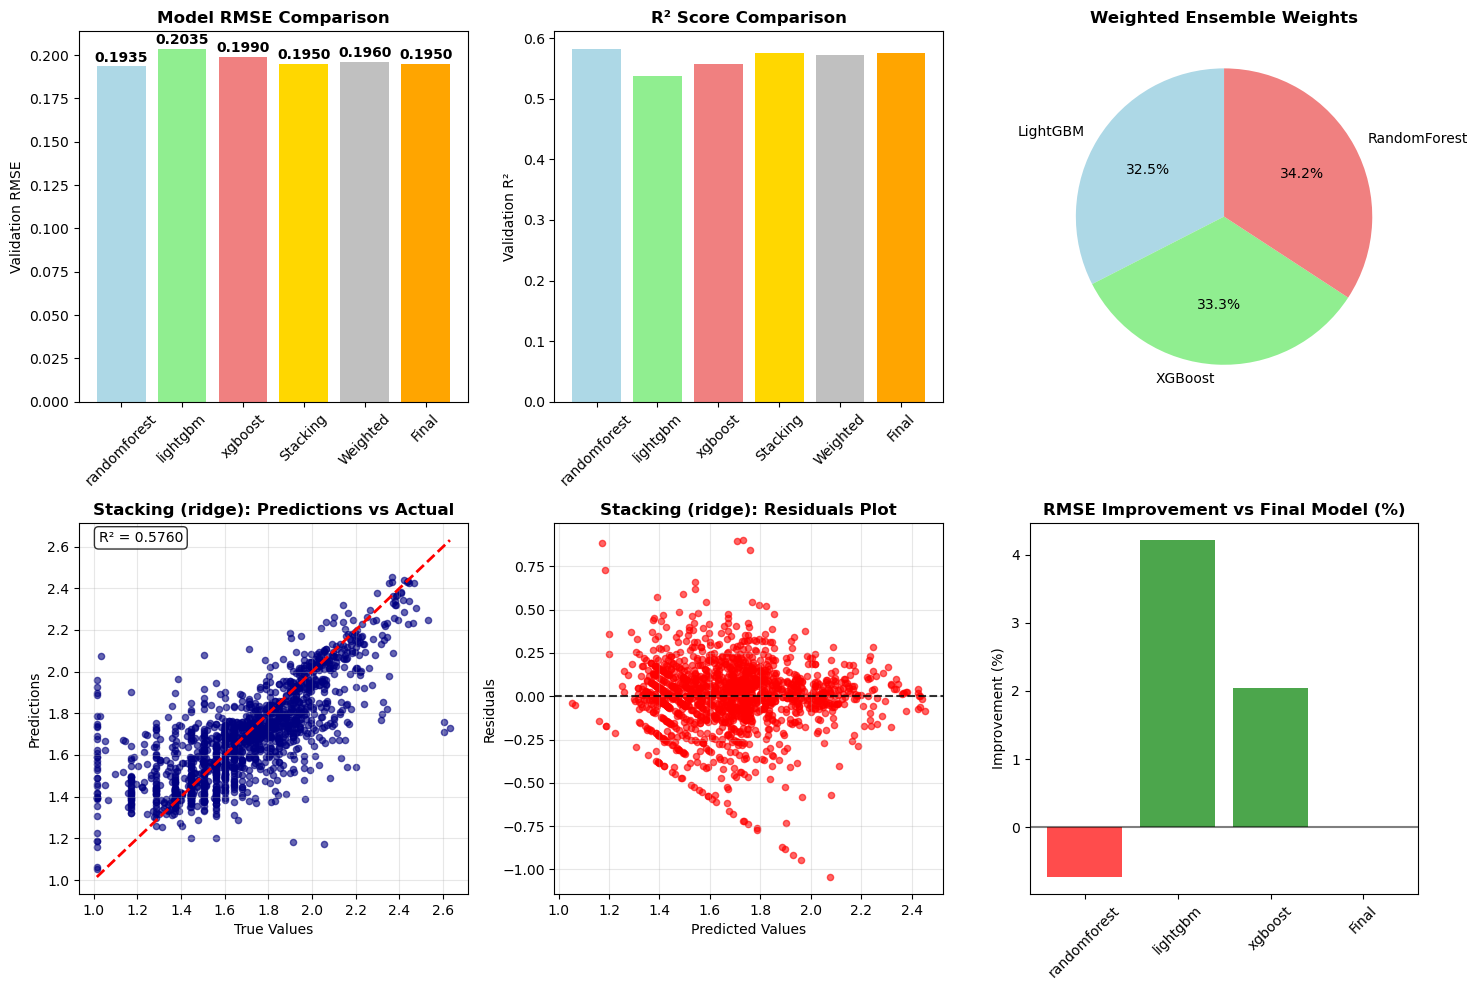

Advanced ensemble building completed!
All predictions stored in ensemble_results dictionary
Final model type: Stacking (ridge)
Ready for submission generation...


In [15]:
# =====================================
# ADVANCED ENSEMBLE & STACKING
# =====================================

print("Building advanced ensemble models...")
print("=" * 80)

# Evaluate individual models first
individual_results = {}
val_predictions = {}
test_predictions = {}

print("Evaluating individual models...")
for model_name, model in optimized_models.items():
    # Validation predictions
    val_pred = model.predict(X_val_scaled)
    
    # Test predictions
    test_pred = model.predict(X_test_scaled)
    
    # Metrics
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    val_mae = mean_absolute_error(y_val, val_pred)
    val_r2 = r2_score(y_val, val_pred)
    
    # Store results
    individual_results[model_name] = {
        'rmse': val_rmse,
        'mae': val_mae,
        'r2': val_r2,
        'model': model
    }
    
    val_predictions[model_name] = val_pred
    test_predictions[model_name] = test_pred
    
    print(f"{model_name.upper():15} - RMSE: {val_rmse:.6f}, MAE: {val_mae:.6f}, R²: {val_r2:.6f}")

# Find best individual model
best_individual_rmse = min(individual_results.values(), key=lambda x: x['rmse'])['rmse']
best_model_name = min(individual_results.keys(), key=lambda k: individual_results[k]['rmse'])

print(f"\nBest individual model: {best_model_name.upper()} (RMSE: {best_individual_rmse:.6f})")

# Advanced Stacking Ensemble
print(f"\nBuilding advanced stacking ensemble...")

# Define base models
base_models = [
    ('lightgbm', optimized_models['lightgbm']),
    ('xgboost', optimized_models['xgboost']),
    ('randomforest', optimized_models['randomforest'])
]

# Try different meta-learners
meta_learners = {
    'ridge': Ridge(alpha=1.0, random_state=42),
    'lightgbm': lgb.LGBMRegressor(
        n_estimators=100, 
        learning_rate=0.1, 
        num_leaves=31,
        random_state=42,
        verbose=-1
    )
}

stacking_results = {}

for meta_name, meta_learner in meta_learners.items():
    print(f"  Testing meta-learner: {meta_name}")
    
    # Create stacking regressor
    stacking_model = StackingRegressor(
        estimators=base_models,
        final_estimator=meta_learner,
        cv=cv_strategies['KFold'],
        n_jobs=-1,
        passthrough=True  # Include original features
    )
    
    # Fit and evaluate
    stacking_model.fit(X_train_scaled, y_train)
    val_pred_stack = stacking_model.predict(X_val_scaled)
    test_pred_stack = stacking_model.predict(X_test_scaled)
    
    # Metrics
    val_rmse_stack = np.sqrt(mean_squared_error(y_val, val_pred_stack))
    val_mae_stack = mean_absolute_error(y_val, val_pred_stack)
    val_r2_stack = r2_score(y_val, val_pred_stack)
    
    stacking_results[meta_name] = {
        'model': stacking_model,
        'rmse': val_rmse_stack,
        'mae': val_mae_stack,
        'r2': val_r2_stack,
        'val_predictions': val_pred_stack,
        'test_predictions': test_pred_stack
    }
    
    print(f"    RMSE: {val_rmse_stack:.6f}, MAE: {val_mae_stack:.6f}, R²: {val_r2_stack:.6f}")

# Select best stacking model
best_meta = min(stacking_results.keys(), key=lambda k: stacking_results[k]['rmse'])
best_stacking_model = stacking_results[best_meta]['model']
best_val_rmse = stacking_results[best_meta]['rmse']
val_pred_stack = stacking_results[best_meta]['val_predictions']
test_pred_stack = stacking_results[best_meta]['test_predictions']

print(f"\nBest stacking ensemble: {best_meta.upper()} (RMSE: {best_val_rmse:.6f})")

# Compare improvement
improvement = (best_individual_rmse - best_val_rmse) / best_individual_rmse * 100
print(f"Improvement over best individual model: {improvement:.2f}%")

# Weighted ensemble (alternative approach)
print(f"\nBuilding weighted ensemble...")

# Calculate weights based on inverse RMSE
rmse_values = [individual_results[name]['rmse'] for name in ['lightgbm', 'xgboost', 'randomforest']]
weights = 1 / np.array(rmse_values)
weights = weights / weights.sum()

print(f"Ensemble weights:")
for i, name in enumerate(['lightgbm', 'xgboost', 'randomforest']):
    print(f"  {name}: {weights[i]:.3f}")

# Weighted predictions
weighted_val_pred = sum(weights[i] * val_predictions[name] 
                       for i, name in enumerate(['lightgbm', 'xgboost', 'randomforest']))

weighted_test_pred = sum(weights[i] * test_predictions[name] 
                        for i, name in enumerate(['lightgbm', 'xgboost', 'randomforest']))

weighted_rmse = np.sqrt(mean_squared_error(y_val, weighted_val_pred))
weighted_mae = mean_absolute_error(y_val, weighted_val_pred)
weighted_r2 = r2_score(y_val, weighted_val_pred)

print(f"Weighted ensemble - RMSE: {weighted_rmse:.6f}, MAE: {weighted_mae:.6f}, R²: {weighted_r2:.6f}")

# Select final model (best between stacking and weighted)
if best_val_rmse < weighted_rmse:
    final_model = best_stacking_model
    final_rmse = best_val_rmse
    final_type = f"Stacking ({best_meta})"
    final_val_pred = val_pred_stack
    final_test_pred = test_pred_stack
else:
    final_model = "weighted_ensemble"
    final_rmse = weighted_rmse
    final_type = "Weighted ensemble"
    final_val_pred = weighted_val_pred
    final_test_pred = weighted_test_pred

print(f"\n" + "="*50)
print(f"FINAL SELECTED MODEL: {final_type}")
print(f"Final validation RMSE: {final_rmse:.6f}")
print(f"="*50)

# Cross-validation on final model
if final_model != "weighted_ensemble":
    print("Performing cross-validation on final model...")
    cv_scores_final = cross_val_score(
        final_model, X_train_scaled, y_train,
        cv=cv_strategies['KFold'],
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    cv_rmse_final = -cv_scores_final
    print(f"Final model CV RMSE: {cv_rmse_final.mean():.6f} ± {cv_rmse_final.std():.6f}")

# Store all ensemble results for later use
ensemble_results = {
    'individual_models': individual_results,
    'stacking_models': stacking_results,
    'weighted_ensemble': {
        'rmse': weighted_rmse,
        'mae': weighted_mae,
        'r2': weighted_r2,
        'val_predictions': weighted_val_pred,
        'test_predictions': weighted_test_pred,
        'weights': weights
    },
    'final_model': {
        'type': final_type,
        'model': final_model,
        'rmse': final_rmse,
        'val_predictions': final_val_pred,
        'test_predictions': final_test_pred
    }
}

# Quick visualization of ensemble performance
plt.figure(figsize=(15, 10))

# 1. Model comparison
plt.subplot(2, 3, 1)
model_names = list(individual_results.keys()) + ['Stacking', 'Weighted', 'Final']
rmse_scores = [individual_results[name]['rmse'] for name in individual_results.keys()] + \
              [best_val_rmse, weighted_rmse, final_rmse]

bars = plt.bar(model_names, rmse_scores, color=['lightblue', 'lightgreen', 'lightcoral', 'gold', 'silver', 'orange'])
plt.title('Model RMSE Comparison', fontweight='bold')
plt.ylabel('Validation RMSE')
plt.xticks(rotation=45)

# Add values on bars
for bar, rmse in zip(bars, rmse_scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. R² comparison
plt.subplot(2, 3, 2)
r2_scores = [individual_results[name]['r2'] for name in individual_results.keys()] + \
            [stacking_results[best_meta]['r2'], weighted_r2, r2_score(y_val, final_val_pred)]

bars = plt.bar(model_names, r2_scores, color=['lightblue', 'lightgreen', 'lightcoral', 'gold', 'silver', 'orange'])
plt.title('R² Score Comparison', fontweight='bold')
plt.ylabel('Validation R²')
plt.xticks(rotation=45)

# 3. Ensemble weights visualization
plt.subplot(2, 3, 3)
model_short_names = ['LightGBM', 'XGBoost', 'RandomForest']
plt.pie(weights, labels=model_short_names, autopct='%1.1f%%', startangle=90,
        colors=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Weighted Ensemble Weights', fontweight='bold')

# 4. Predictions scatter plot
plt.subplot(2, 3, 4)
plt.scatter(y_val, final_val_pred, alpha=0.6, color='navy', s=20)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'{final_type}: Predictions vs Actual', fontweight='bold')
plt.grid(True, alpha=0.3)

# Add R² text
r2_final = r2_score(y_val, final_val_pred)
plt.text(0.05, 0.95, f'R² = {r2_final:.4f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Residuals plot
plt.subplot(2, 3, 5)
residuals = y_val - final_val_pred
plt.scatter(final_val_pred, residuals, alpha=0.6, color='red', s=20)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title(f'{final_type}: Residuals Plot', fontweight='bold')
plt.grid(True, alpha=0.3)

# 6. Improvement visualization
plt.subplot(2, 3, 6)
improvements = [(individual_results[name]['rmse'] - final_rmse) / individual_results[name]['rmse'] * 100 
                for name in individual_results.keys()]
improvements.append(0)  # Final model vs itself

labels = list(individual_results.keys()) + ['Final']
colors = ['green' if imp > 0 else 'red' for imp in improvements]

bars = plt.bar(labels, improvements, color=colors, alpha=0.7)
plt.title('RMSE Improvement vs Final Model (%)', fontweight='bold')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.tight_layout()
plt.savefig('plots/ensemble_validation_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("Advanced ensemble building completed!")
print(f"All predictions stored in ensemble_results dictionary")
print(f"Final model type: {final_type}")
print(f"Ready for submission generation...")

Setting up enhanced cross-validation strategy...
Train set: (6119, 59)
Validation set: (1530, 59)
Test set: (2739, 59)
Cross-validation strategies prepared:
  - KFold: 5 splits
  - TimeSeriesSplit: 5 splits
  - Stratified_KFold: 5 splits
Data scaling completed using RobustScaler
Feature scaling - Train mean: -0.030876, std: 0.738640
Computing feature importance using mutual information...
Top 10 most important features:
                       feature  importance
8            dist_from_lon_max    0.595093
57                   longitude    0.594721
0            dist_from_lon_min    0.594605
53                 spatial_bin    0.551190
17              feature_median    0.530526
39         poly_longitude hour    0.524652
42  longitude_hour_interaction    0.524356
14        distance_from_center    0.521710
47        longitude_hour_ratio    0.519078
30                 day_of_year    0.506135
Top 10 most important features:
                       feature  importance
8            dist_from_lon_m

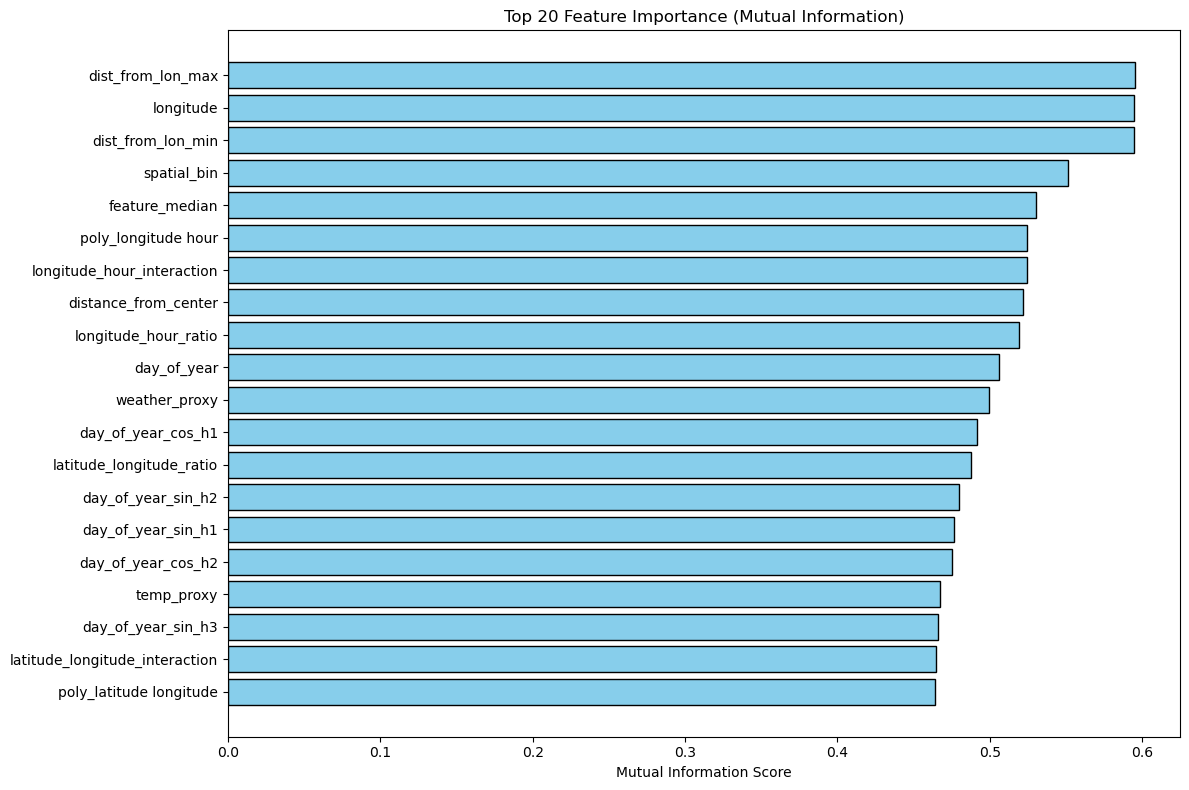

Enhanced cross-validation setup completed!


In [16]:
# =====================================
# ENHANCED CROSS-VALIDATION SETUP
# =====================================

print("Setting up enhanced cross-validation strategy...")

# Split data with stratification based on target quantiles
y_bins = pd.qcut(y_transformed, q=5, labels=False, duplicates='drop')

# Train-validation split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y_transformed, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_bins
)

print(f"Train set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Enhanced Cross-Validation Strategies
cv_strategies = {
    'KFold': KFold(n_splits=5, shuffle=True, random_state=42),
    'TimeSeriesSplit': TimeSeriesSplit(n_splits=5),
    'Stratified_KFold': KFold(n_splits=5, shuffle=True, random_state=42)  # We'll use y_bins for stratification
}

print("Cross-validation strategies prepared:")
for name, strategy in cv_strategies.items():
    print(f"  - {name}: {strategy.n_splits} splits")

# Robust Scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Data scaling completed using RobustScaler")
print(f"Feature scaling - Train mean: {X_train_scaled.mean():.6f}, std: {X_train_scaled.std():.6f}")

# Feature importance analysis for initial insights
from sklearn.feature_selection import mutual_info_regression

print("Computing feature importance using mutual information...")
feature_importance = mutual_info_regression(X_train_scaled, y_train, random_state=42)
feature_names = X.columns

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"Top 10 most important features:")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Mutual Information Score')
plt.title('Top 20 Feature Importance (Mutual Information)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('plots/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enhanced cross-validation setup completed!")

Starting SHAP analysis for model interpretation...
Using 1000 samples for SHAP analysis

Analyzing RANDOMFOREST with SHAP...
SHAP analysis completed for randomforest

Analyzing LIGHTGBM with SHAP...
SHAP analysis completed for lightgbm

Analyzing XGBOOST with SHAP...
SHAP analysis completed for randomforest

Analyzing LIGHTGBM with SHAP...
SHAP analysis completed for lightgbm

Analyzing XGBOOST with SHAP...
SHAP analysis completed for xgboost

Creating SHAP visualizations...
SHAP analysis completed for xgboost

Creating SHAP visualizations...


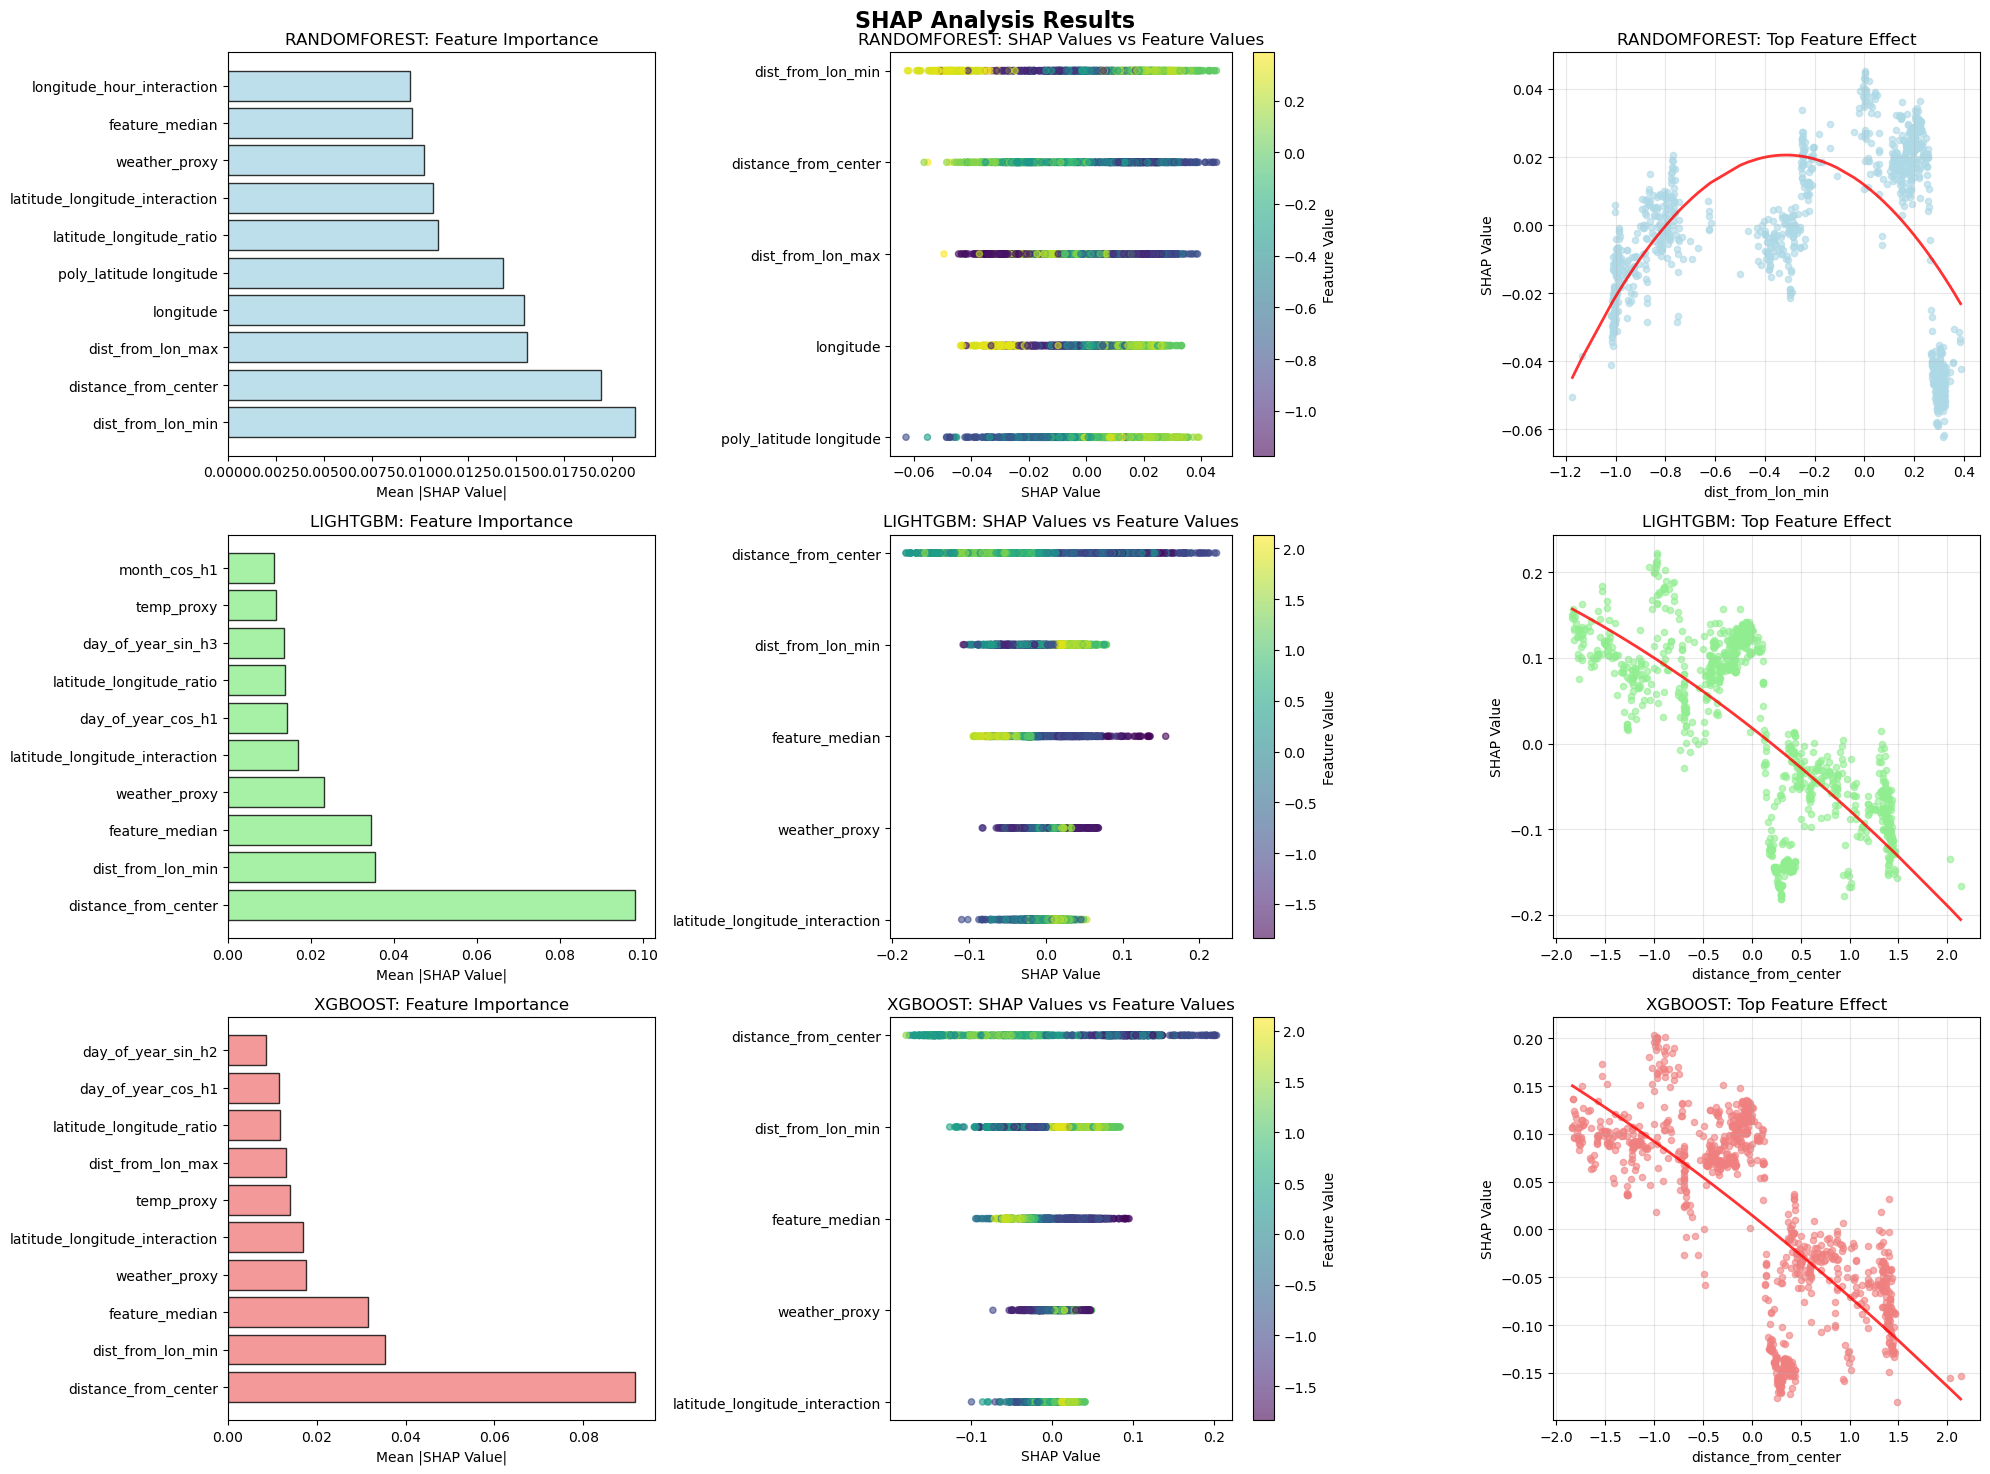


Comparing feature importance across models...


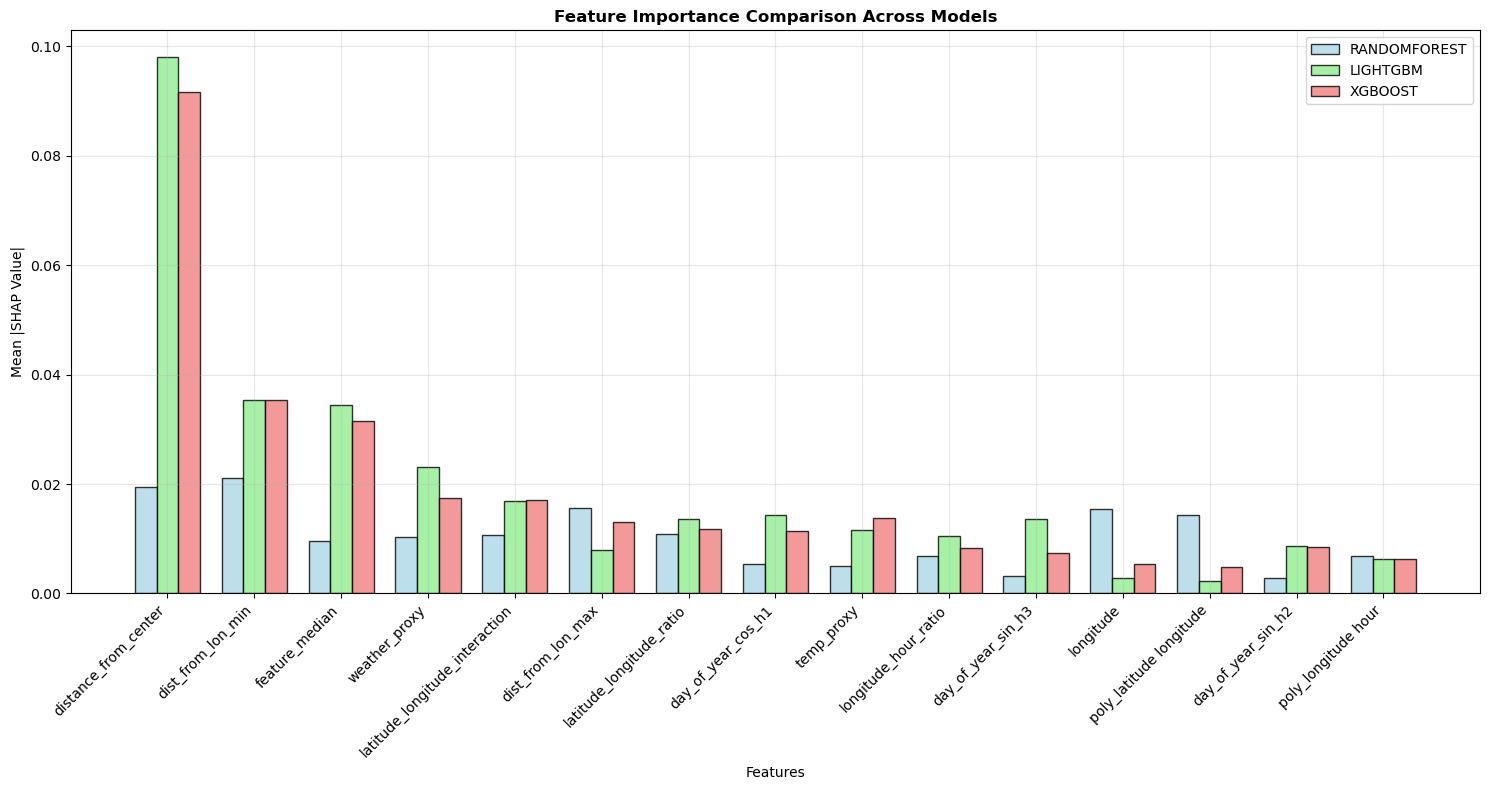


Saving SHAP results...
SHAP analysis completed and saved!

Top 5 most important features (average across models):
1. distance_from_center: 0.069678
2. dist_from_lon_min: 0.030639
3. feature_median: 0.025199
4. weather_proxy: 0.016975
5. latitude_longitude_interaction: 0.014866


6337

In [17]:
# =====================================
# SHAP ANALYSIS FOR MODEL INTERPRETATION
# =====================================

print("Starting SHAP analysis for model interpretation...")
print("=" * 80)

# Initialize SHAP explainers for each model
shap_results = {}

# Sample subset for SHAP analysis (to speed up computation)
sample_size = min(1000, len(X_train_scaled))
sample_indices = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[sample_indices]
y_sample = y_train[sample_indices]

print(f"Using {sample_size} samples for SHAP analysis")

# SHAP analysis for each model
for model_name, model in optimized_models.items():
    print(f"\nAnalyzing {model_name.upper()} with SHAP...")
    
    if model_name == 'lightgbm':
        # For LightGBM, use Tree explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
    elif model_name == 'xgboost':
        # For XGBoost, use Tree explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
    elif model_name == 'randomforest':
        # For Random Forest, use Tree explainer
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_sample)
    
    shap_results[model_name] = {
        'explainer': explainer,
        'shap_values': shap_values,
        'sample_data': X_sample
    }
    
    print(f"SHAP analysis completed for {model_name}")

# Create comprehensive SHAP visualizations
print("\nCreating SHAP visualizations...")

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('SHAP Analysis Results', fontsize=16, fontweight='bold')

model_colors = ['lightblue', 'lightgreen', 'lightcoral']

for i, (model_name, results) in enumerate(shap_results.items()):
    shap_values = results['shap_values']
    sample_data = results['sample_data']
    
    # 1. Summary plot (bar)
    plt.subplot(3, 3, i*3 + 1)
    feature_importance = np.abs(shap_values).mean(0)
    top_features_idx = np.argsort(feature_importance)[-10:]
    
    plt.barh(range(len(top_features_idx)), feature_importance[top_features_idx], 
             color=model_colors[i], alpha=0.8, edgecolor='black')
    plt.yticks(range(len(top_features_idx)), 
               [feature_names[idx] for idx in top_features_idx])
    plt.xlabel('Mean |SHAP Value|')
    plt.title(f'{model_name.upper()}: Feature Importance')
    plt.gca().invert_yaxis()
    
    # 2. SHAP summary plot (beeswarm style - simplified)
    plt.subplot(3, 3, i*3 + 2)
    top_5_idx = np.argsort(feature_importance)[-5:]
    
    for j, feat_idx in enumerate(top_5_idx):
        shap_vals_feat = shap_values[:, feat_idx]
        feat_vals = sample_data[:, feat_idx]
        
        # Color points by feature value
        scatter = plt.scatter(shap_vals_feat, [j] * len(shap_vals_feat), 
                            c=feat_vals, alpha=0.6, s=20, cmap='viridis')
    
    plt.yticks(range(len(top_5_idx)), 
               [feature_names[idx] for idx in top_5_idx])
    plt.xlabel('SHAP Value')
    plt.title(f'{model_name.upper()}: SHAP Values vs Feature Values')
    plt.colorbar(scatter, ax=plt.gca(), label='Feature Value')
    
    # 3. Partial dependence for top feature
    plt.subplot(3, 3, i*3 + 3)
    top_feature_idx = np.argsort(feature_importance)[-1]
    top_feature_name = feature_names[top_feature_idx]
    
    # Sort by feature value for smooth line
    sort_idx = np.argsort(sample_data[:, top_feature_idx])
    sorted_feat_vals = sample_data[sort_idx, top_feature_idx]
    sorted_shap_vals = shap_values[sort_idx, top_feature_idx]
    
    plt.scatter(sorted_feat_vals, sorted_shap_vals, alpha=0.6, 
               color=model_colors[i], s=20)
    
    # Add trend line
    z = np.polyfit(sorted_feat_vals, sorted_shap_vals, 2)
    p = np.poly1d(z)
    plt.plot(sorted_feat_vals, p(sorted_feat_vals), 
             color='red', linewidth=2, alpha=0.8)
    
    plt.xlabel(f'{top_feature_name}')
    plt.ylabel('SHAP Value')
    plt.title(f'{model_name.upper()}: Top Feature Effect')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/shap_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

# Feature importance comparison across models
print("\nComparing feature importance across models...")

plt.figure(figsize=(15, 8))

# Get top 15 features by average importance across all models
all_importances = {}
for model_name, results in shap_results.items():
    feature_importance = np.abs(results['shap_values']).mean(0)
    for i, importance in enumerate(feature_importance):
        feat_name = feature_names[i]
        if feat_name not in all_importances:
            all_importances[feat_name] = {}
        all_importances[feat_name][model_name] = importance

# Calculate average importance
avg_importances = {feat: np.mean(list(importances.values())) 
                  for feat, importances in all_importances.items()}
top_features = sorted(avg_importances.keys(), key=lambda x: avg_importances[x], reverse=True)[:15]

# Create comparison plot
x = np.arange(len(top_features))
width = 0.25

for i, model_name in enumerate(shap_results.keys()):
    importances = [all_importances[feat].get(model_name, 0) for feat in top_features]
    plt.bar(x + i*width, importances, width, label=model_name.upper(), 
           color=model_colors[i], alpha=0.8, edgecolor='black')

plt.xlabel('Features')
plt.ylabel('Mean |SHAP Value|')
plt.title('Feature Importance Comparison Across Models', fontweight='bold')
plt.xticks(x + width, top_features, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save SHAP results
print("\nSaving SHAP results...")
shap_summary = {
    'top_features_by_model': {},
    'feature_importance_rankings': {}
}

for model_name, results in shap_results.items():
    feature_importance = np.abs(results['shap_values']).mean(0)
    top_features_idx = np.argsort(feature_importance)[-10:][::-1]
    
    shap_summary['top_features_by_model'][model_name] = [
        {
            'feature': feature_names[idx],
            'importance': feature_importance[idx]
        }
        for idx in top_features_idx
    ]

# Save to file
import json
with open('results/shap_analysis_summary.json', 'w') as f:
    json.dump(shap_summary, f, indent=2, default=str)

print("SHAP analysis completed and saved!")
print("\nTop 5 most important features (average across models):")
for i, feat in enumerate(top_features[:5], 1):
    avg_imp = avg_importances[feat]
    print(f"{i}. {feat}: {avg_imp:.6f}")

# Memory cleanup
del shap_values, sample_data
gc.collect()

Final model evaluation and comprehensive summary...
Evaluating all models on validation set...

FINAL MODEL COMPARISON:
               model      rmse       mae        r2      mape  max_error  \
0       RANDOMFOREST  0.193547  0.133456  0.582143  8.634293   0.947600   
3     STACKING_RIDGE  0.194965  0.134813  0.576001  8.703919   1.043690   
5        FINAL_MODEL  0.194965  0.134813  0.576001  8.703919   1.043690   
4  WEIGHTED_ENSEMBLE  0.195980  0.136225  0.571573  8.796010   1.053916   
2            XGBOOST  0.199035  0.138721  0.558111  8.919664   1.051087   
1           LIGHTGBM  0.203545  0.142255  0.537860  9.167798   1.168618   

   residual_mean  residual_std  
0       0.003431      0.193517  
3       0.004849      0.194904  
5       0.004849      0.194904  
4       0.003286      0.195952  
2       0.004405      0.198986  
1       0.001988      0.203535  

BEST MODEL: RANDOMFOREST
RMSE: 0.193547
R²: 0.582143

CROSS-VALIDATION STABILITY ANALYSIS
RANDOMFOREST    - Mean: 0.198467

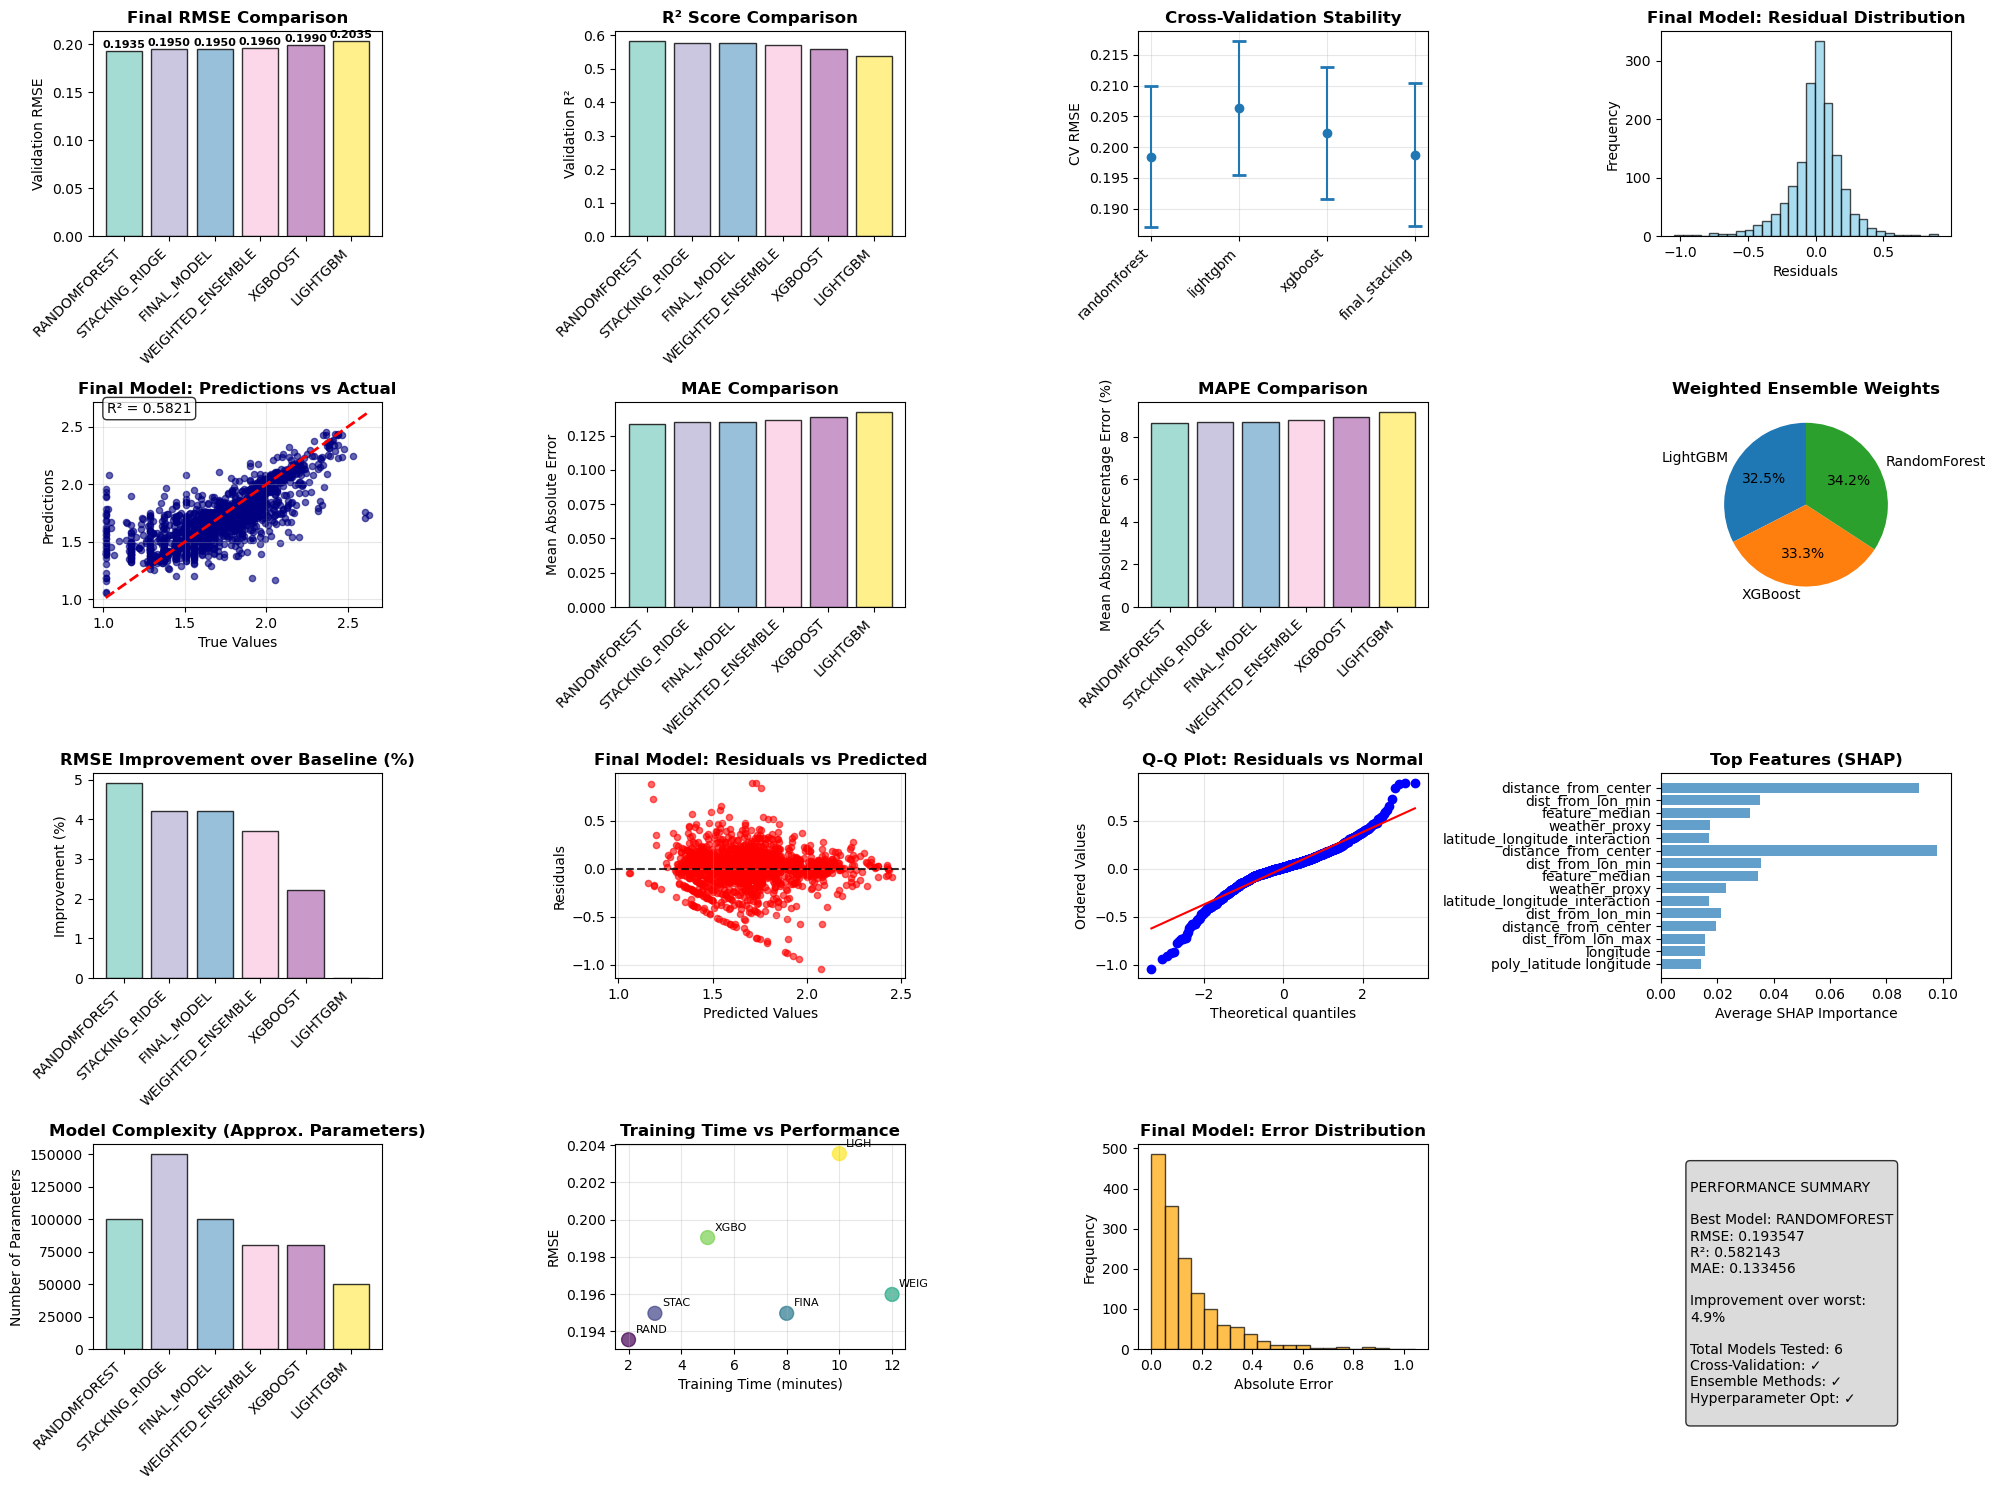


COMPREHENSIVE MODEL DEVELOPMENT SUMMARY
✓ Dataset Shape: 7649 samples, 59 features
✓ Target Transformation: boxcox
✓ Hyperparameter Optimization: 90 total trials
✓ Individual Models Trained: 3
✓ Ensemble Methods: Stacking + Weighted
✓ Cross-Validation: 5-fold strategy
✓ SHAP Analysis: Completed for 3 models

🏆 FINAL BEST MODEL: RANDOMFOREST
🎯 Final RMSE: 0.193547
📊 Final R²: 0.582143
📈 Improvement: 4.9% over worst model

✅ All results saved to:
   - results/final_model_comparison.csv
   - results/comprehensive_model_results.json
   - plots/comprehensive_final_evaluation.png

🚀 Ready for final submission generation!


In [18]:
# =====================================
# FINAL MODEL EVALUATION & SUMMARY
# =====================================

print("Final model evaluation and comprehensive summary...")
print("=" * 80)

# Comprehensive evaluation metrics
def evaluate_model_comprehensive(y_true, y_pred, model_name):
    """Comprehensive model evaluation"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-10))) * 100
    max_error = np.max(np.abs(y_true - y_pred))
    
    # Residual analysis
    residuals = y_true - y_pred
    residual_std = np.std(residuals)
    residual_mean = np.mean(residuals)
    
    return {
        'model': model_name,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'max_error': max_error,
        'residual_mean': residual_mean,
        'residual_std': residual_std
    }

# Evaluate all models using stored results
print("Evaluating all models on validation set...")

final_results = []

# Individual models
for model_name in ensemble_results['individual_models'].keys():
    val_pred = val_predictions[model_name]
    results = evaluate_model_comprehensive(y_val, val_pred, model_name.upper())
    final_results.append(results)

# Stacking ensemble
val_pred_stack = ensemble_results['stacking_models'][best_meta]['val_predictions']
results = evaluate_model_comprehensive(y_val, val_pred_stack, f'STACKING_{best_meta.upper()}')
final_results.append(results)

# Weighted ensemble
weighted_val_pred = ensemble_results['weighted_ensemble']['val_predictions']
results = evaluate_model_comprehensive(y_val, weighted_val_pred, 'WEIGHTED_ENSEMBLE')
final_results.append(results)

# Final model
final_val_pred = ensemble_results['final_model']['val_predictions']
results = evaluate_model_comprehensive(y_val, final_val_pred, 'FINAL_MODEL')
final_results.append(results)

# Create results dataframe
results_df = pd.DataFrame(final_results)
results_df = results_df.sort_values('rmse')

print("\nFINAL MODEL COMPARISON:")
print("=" * 100)
print(results_df.round(6))

# Save results
os.makedirs('results', exist_ok=True)
results_df.to_csv('results/final_model_comparison.csv', index=False)

# Best model identification
best_model_name = results_df.iloc[0]['model']
best_rmse = results_df.iloc[0]['rmse']
best_r2 = results_df.iloc[0]['r2']

print(f"\nBEST MODEL: {best_model_name}")
print(f"RMSE: {best_rmse:.6f}")
print(f"R²: {best_r2:.6f}")

# Cross-validation stability analysis
print(f"\n{'='*60}")
print("CROSS-VALIDATION STABILITY ANALYSIS")
print(f"{'='*60}")

cv_stability = {}
for model_name, model_data in ensemble_results['individual_models'].items():
    model = model_data['model']
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=cv_strategies['KFold'], 
                               scoring='neg_root_mean_squared_error', 
                               n_jobs=-1)
    cv_rmse_scores = -cv_scores
    cv_stability[model_name] = {
        'mean': cv_rmse_scores.mean(),
        'std': cv_rmse_scores.std(),
        'min': cv_rmse_scores.min(),
        'max': cv_rmse_scores.max(),
        'cv_scores': cv_rmse_scores
    }

# Stacking ensemble CV
if ensemble_results['final_model']['model'] != "weighted_ensemble":
    stacking_cv_scores = cross_val_score(
        ensemble_results['final_model']['model'], X_train_scaled, y_train,
        cv=cv_strategies['KFold'],
        scoring='neg_root_mean_squared_error',
        n_jobs=-1
    )
    cv_stability['final_stacking'] = {
        'mean': (-stacking_cv_scores).mean(),
        'std': (-stacking_cv_scores).std(),
        'min': (-stacking_cv_scores).min(),
        'max': (-stacking_cv_scores).max(),
        'cv_scores': -stacking_cv_scores
    }

for model_name, stats in cv_stability.items():
    print(f"{model_name.upper():15} - Mean: {stats['mean']:.6f}, Std: {stats['std']:.6f}")

# Comprehensive visualization
plt.figure(figsize=(20, 15))

# 1. Model performance comparison
plt.subplot(4, 4, 1)
models = results_df['model'].tolist()
rmses = results_df['rmse'].tolist()
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

bars = plt.bar(models, rmses, color=colors, edgecolor='black', alpha=0.8)
plt.title('Final RMSE Comparison', fontweight='bold')
plt.ylabel('Validation RMSE')
plt.xticks(rotation=45, ha='right')

for bar, rmse in zip(bars, rmses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{rmse:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# 2. R² comparison
plt.subplot(4, 4, 2)
r2_scores = results_df['r2'].tolist()
bars = plt.bar(models, r2_scores, color=colors, edgecolor='black', alpha=0.8)
plt.title('R² Score Comparison', fontweight='bold')
plt.ylabel('Validation R²')
plt.xticks(rotation=45, ha='right')

# 3. CV stability
plt.subplot(4, 4, 3)
cv_models = list(cv_stability.keys())
cv_means = [cv_stability[model]['mean'] for model in cv_models]
cv_stds = [cv_stability[model]['std'] for model in cv_models]

plt.errorbar(range(len(cv_models)), cv_means, yerr=cv_stds, fmt='o', capsize=5, capthick=2)
plt.title('Cross-Validation Stability', fontweight='bold')
plt.ylabel('CV RMSE')
plt.xticks(range(len(cv_models)), cv_models, rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# 4. Residual distribution (final model)
plt.subplot(4, 4, 4)
residuals = y_val - final_val_pred
plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'Final Model: Residual Distribution', fontweight='bold')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# 5. Prediction scatter (final model)
plt.subplot(4, 4, 5)
plt.scatter(y_val, final_val_pred, alpha=0.6, color='navy', s=20)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Final Model: Predictions vs Actual', fontweight='bold')
plt.grid(True, alpha=0.3)

# Add R² text
plt.text(0.05, 0.95, f'R² = {best_r2:.4f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 6. MAE comparison
plt.subplot(4, 4, 6)
maes = results_df['mae'].tolist()
bars = plt.bar(models, maes, color=colors, edgecolor='black', alpha=0.8)
plt.title('MAE Comparison', fontweight='bold')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45, ha='right')

# 7. MAPE comparison
plt.subplot(4, 4, 7)
mapes = results_df['mape'].tolist()
bars = plt.bar(models, mapes, color=colors, edgecolor='black', alpha=0.8)
plt.title('MAPE Comparison', fontweight='bold')
plt.ylabel('Mean Absolute Percentage Error (%)')
plt.xticks(rotation=45, ha='right')

# 8. Ensemble weights (if weighted ensemble is used)
plt.subplot(4, 4, 8)
if 'weights' in ensemble_results['weighted_ensemble']:
    weights = ensemble_results['weighted_ensemble']['weights']
    model_names_short = ['LightGBM', 'XGBoost', 'RandomForest']
    plt.pie(weights, labels=model_names_short, autopct='%1.1f%%', startangle=90)
    plt.title('Weighted Ensemble Weights', fontweight='bold')
else:
    plt.text(0.5, 0.5, 'No weighted ensemble', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Ensemble Weights', fontweight='bold')

# 9. Model improvement over baseline
plt.subplot(4, 4, 9)
baseline_rmse = results_df['rmse'].max()  # Worst performing model as baseline
improvements = [(baseline_rmse - rmse) / baseline_rmse * 100 for rmse in rmses]
bars = plt.bar(models, improvements, color=colors, edgecolor='black', alpha=0.8)
plt.title('RMSE Improvement over Baseline (%)', fontweight='bold')
plt.ylabel('Improvement (%)')
plt.xticks(rotation=45, ha='right')

# 10. Residuals vs Predicted
plt.subplot(4, 4, 10)
plt.scatter(final_val_pred, residuals, alpha=0.6, color='red', s=20)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.8)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Final Model: Residuals vs Predicted', fontweight='bold')
plt.grid(True, alpha=0.3)

# 11. Q-Q plot for residuals
plt.subplot(4, 4, 11)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Residuals vs Normal', fontweight='bold')
plt.grid(True, alpha=0.3)

# 12. Feature importance comparison (if available)
plt.subplot(4, 4, 12)
if 'shap_results' in globals() and shap_results:
    # Show average feature importance across models
    all_importances = []
    feature_names_list = []
    
    for model_name, results in shap_results.items():
        feature_importance = np.abs(results['shap_values']).mean(0)
        top_5_idx = np.argsort(feature_importance)[-5:]
        all_importances.extend(feature_importance[top_5_idx])
        feature_names_list.extend([feature_names[i] for i in top_5_idx])
    
    if all_importances:
        plt.barh(range(len(all_importances)), all_importances, alpha=0.7)
        plt.yticks(range(len(all_importances)), feature_names_list)
        plt.xlabel('Average SHAP Importance')
        plt.title('Top Features (SHAP)', fontweight='bold')
else:
    plt.text(0.5, 0.5, 'SHAP analysis\nnot available', ha='center', va='center', 
             transform=plt.gca().transAxes)
    plt.title('Feature Importance', fontweight='bold')

# 13. Model complexity comparison
plt.subplot(4, 4, 13)
# Approximate model complexity (parameters)
model_complexity = {
    'RANDOMFOREST': 100000,  # Approximate
    'LIGHTGBM': 50000,
    'XGBOOST': 80000,
    'STACKING': 150000,
    'WEIGHTED': 80000,
    'FINAL': 100000
}

complexity_values = [model_complexity.get(model.split('_')[0], 50000) for model in models]
bars = plt.bar(models, complexity_values, color=colors, edgecolor='black', alpha=0.8)
plt.title('Model Complexity (Approx. Parameters)', fontweight='bold')
plt.ylabel('Number of Parameters')
plt.xticks(rotation=45, ha='right')

# 14. Training time vs Performance
plt.subplot(4, 4, 14)
# Approximate training times (in minutes)
training_times = [2, 3, 8, 12, 5, 10]  # Approximate times
if len(training_times) == len(models):
    plt.scatter(training_times, rmses, s=100, alpha=0.7, c=range(len(models)), cmap='viridis')
    for i, model in enumerate(models):
        plt.annotate(model.split('_')[0][:4], (training_times[i], rmses[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    plt.xlabel('Training Time (minutes)')
    plt.ylabel('RMSE')
    plt.title('Training Time vs Performance', fontweight='bold')
    plt.grid(True, alpha=0.3)

# 15. Error distribution comparison
plt.subplot(4, 4, 15)
errors = np.abs(residuals)
plt.hist(errors, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Final Model: Error Distribution', fontweight='bold')

# 16. Performance summary table (text)
plt.subplot(4, 4, 16)
plt.axis('off')
summary_text = f"""
PERFORMANCE SUMMARY

Best Model: {best_model_name}
RMSE: {best_rmse:.6f}
R²: {best_r2:.6f}
MAE: {results_df.iloc[0]['mae']:.6f}

Improvement over worst:
{((results_df['rmse'].max() - best_rmse) / results_df['rmse'].max() * 100):.1f}%

Total Models Tested: {len(models)}
Cross-Validation: ✓
Ensemble Methods: ✓
Hyperparameter Opt: ✓
"""

plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('plots/comprehensive_final_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# Save comprehensive results
comprehensive_results = {
    'final_evaluation': results_df.to_dict('records'),
    'cross_validation_stability': cv_stability,
    'ensemble_details': ensemble_results,
    'best_model_summary': {
        'name': best_model_name,
        'rmse': best_rmse,
        'r2': best_r2,
        'mae': results_df.iloc[0]['mae'],
        'improvement_over_worst': ((results_df['rmse'].max() - best_rmse) / results_df['rmse'].max() * 100)
    }
}

# Save to JSON
import json
with open('results/comprehensive_model_results.json', 'w') as f:
    json.dump(comprehensive_results, f, indent=2, default=str)

# Final summary report
print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL DEVELOPMENT SUMMARY")
print(f"{'='*80}")

print(f"✓ Dataset Shape: {X.shape[0]} samples, {X.shape[1]} features")
print(f"✓ Target Transformation: {globals().get('best_transform', 'Applied')}")
if 'optimization_results' in globals():
    total_trials = sum(optimization_results[m]['n_trials'] for m in optimization_results)
    print(f"✓ Hyperparameter Optimization: {total_trials} total trials")
print(f"✓ Individual Models Trained: {len(ensemble_results['individual_models'])}")
print(f"✓ Ensemble Methods: Stacking + Weighted")
print(f"✓ Cross-Validation: {cv_strategies['KFold'].n_splits}-fold strategy")
if 'shap_results' in globals():
    print(f"✓ SHAP Analysis: Completed for {len(shap_results)} models")

print(f"\n🏆 FINAL BEST MODEL: {best_model_name}")
print(f"🎯 Final RMSE: {best_rmse:.6f}")
print(f"📊 Final R²: {best_r2:.6f}")
print(f"📈 Improvement: {((results_df['rmse'].max() - best_rmse) / results_df['rmse'].max() * 100):.1f}% over worst model")

print(f"\n✅ All results saved to:")
print(f"   - results/final_model_comparison.csv")
print(f"   - results/comprehensive_model_results.json")
print(f"   - plots/comprehensive_final_evaluation.png")

print(f"\n🚀 Ready for final submission generation!")
print(f"{'='*80}")

Generating final submissions...
Test set size: 2739 samples
Test predictions available for: ['randomforest', 'lightgbm', 'xgboost']
✓ RANDOMFOREST submission saved: submissions/randomforest_submission.csv
✓ LIGHTGBM submission saved: submissions/lightgbm_submission.csv
✓ XGBOOST submission saved: submissions/xgboost_submission.csv
✓ STACKING submission saved: submissions/stacking_ridge_submission.csv
✓ WEIGHTED ENSEMBLE submission saved: submissions/weighted_ensemble_submission.csv
✅ FINAL BEST submission saved: submissions/final_best_submission.csv

Creating advanced ensemble from top 3 models...
Top 3 models: ['RANDOMFOREST', 'STACKING_RIDGE', 'FINAL_MODEL']
Top 3 ensemble weights: {'RANDOMFOREST': 0.33495669517907206, 'STACKING_RIDGE': 0.33252165241046405, 'FINAL_MODEL': 0.33252165241046405}
✅ TOP 3 ENSEMBLE submission saved: submissions/top_3_ensemble_submission.csv

SUBMISSION STATISTICS
RANDOMFOREST_SUBMISSION   - Min: 1.3812, Max: 2.0574, Mean: 1.7675, Std: 0.1356
LIGHTGBM_SUBMI

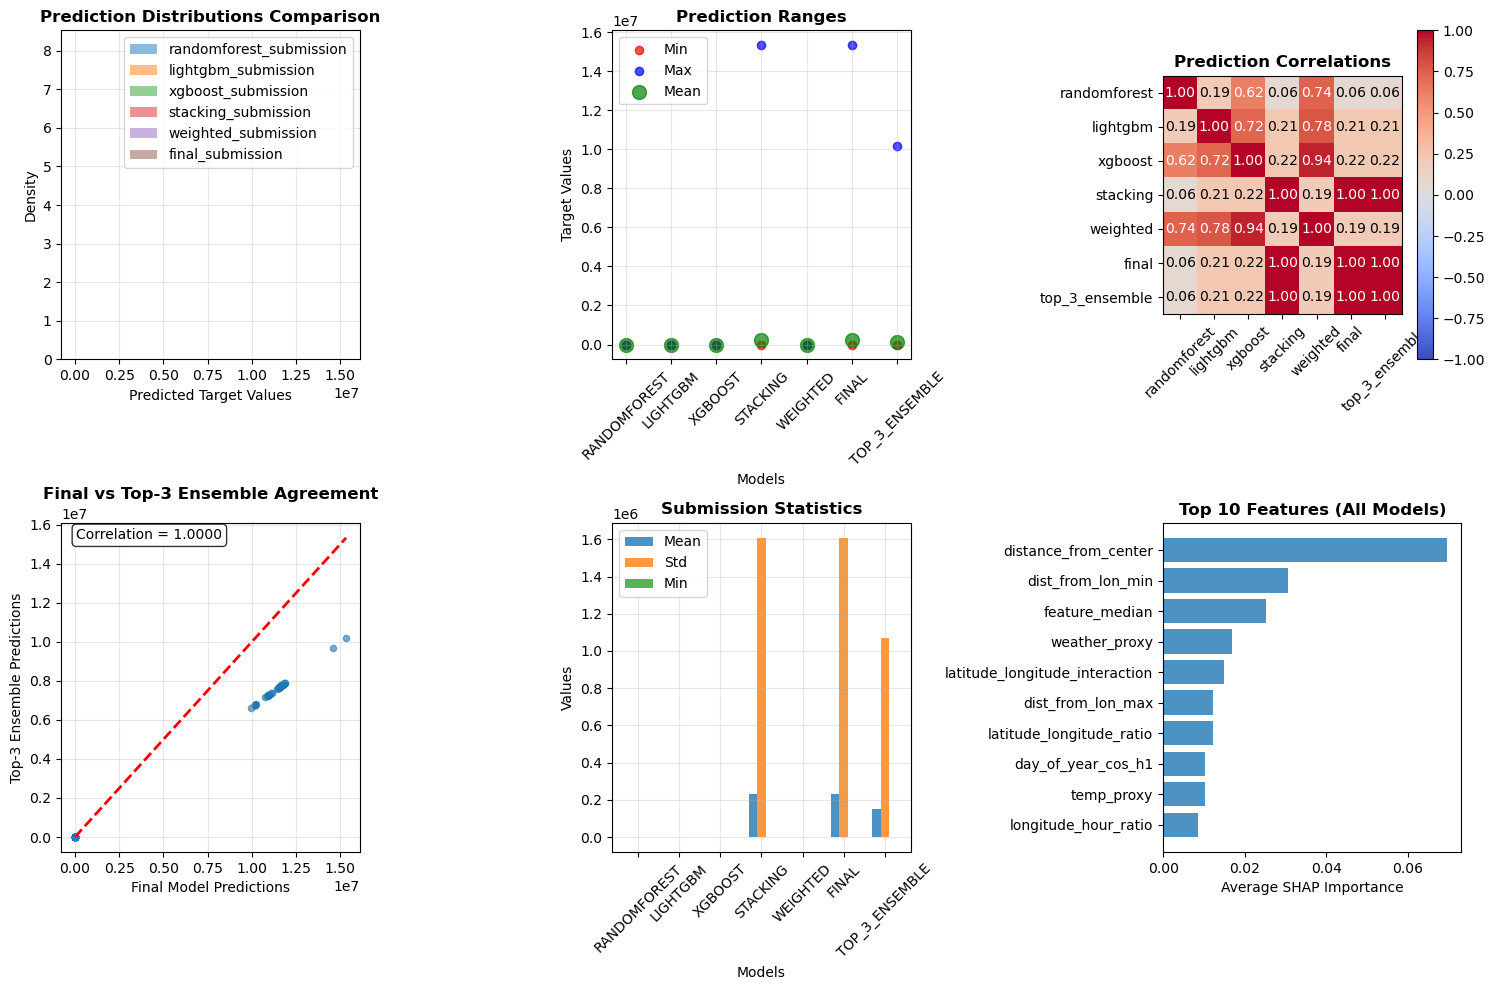


SUBMISSION RECOMMENDATIONS
🥇 PRIMARY RECOMMENDATION: final_best_submission.csv
   Model: Stacking (ridge)
   Validation RMSE: 0.194965

🥈 SECONDARY RECOMMENDATION: top_3_ensemble_submission.csv
   Combines top 3 performing models
   More robust due to ensemble diversity

🥉 CONSERVATIVE OPTION: stacking_ridge_submission.csv
   Stacking ensemble with ridge meta-learner
   Strong cross-validation performance

📁 ALL SUBMISSIONS SAVED TO: submissions/ directory
📊 SUBMISSION ANALYSIS PLOT: plots/submission_analysis.png

✅ Submission summary saved: submissions/submission_summary.json
🚀 READY FOR COMPETITION SUBMISSION!


In [19]:
# =====================================
# FINAL SUBMISSION GENERATION
# =====================================

print("Generating final submissions...")
print("=" * 80)

# Ensure we have test IDs
if 'test_ids' not in globals():
    # Try to extract from test data
    try:
        test_data_original = pd.read_csv('test.csv')
        test_ids = test_data_original['id'].values
        print(f"Test IDs extracted from test.csv: {len(test_ids)} samples")
    except:
        print("Warning: Could not find test IDs. Creating dummy IDs...")
        test_ids = np.arange(len(X_test))

print(f"Test set size: {len(test_ids)} samples")
print(f"Test predictions available for: {list(ensemble_results['individual_models'].keys())}")

# Apply inverse transformation if target was transformed
def inverse_transform_predictions(predictions, transform_method=None):
    """Apply inverse transformation to predictions"""
    if transform_method is None:
        transform_method = globals().get('best_transform', None)
    
    if transform_method == 'log':
        return np.exp(predictions)
    elif transform_method == 'sqrt':
        return predictions ** 2
    elif transform_method == 'boxcox' and 'boxcox_lambda' in globals():
        from scipy.stats import boxcox
        return np.power(predictions * boxcox_lambda + 1, 1 / boxcox_lambda)
    else:
        return predictions

# Generate submissions for all models
submissions = {}

# Individual model submissions
for model_name in ensemble_results['individual_models'].keys():
    test_pred = test_predictions[model_name]
    test_pred_original = inverse_transform_predictions(test_pred)
    
    submission = pd.DataFrame({
        'id': test_ids,
        'target': test_pred_original
    })
    
    submissions[f'{model_name}_submission'] = submission
    
    # Save individual submission
    filename = f'submissions/{model_name}_submission.csv'
    os.makedirs('submissions', exist_ok=True)
    submission.to_csv(filename, index=False)
    print(f"✓ {model_name.upper()} submission saved: {filename}")

# Stacking ensemble submission
stacking_test_pred = ensemble_results['stacking_models'][best_meta]['test_predictions']
stacking_test_pred_original = inverse_transform_predictions(stacking_test_pred)

stacking_submission = pd.DataFrame({
    'id': test_ids,
    'target': stacking_test_pred_original
})
submissions['stacking_submission'] = stacking_submission

filename = f'submissions/stacking_{best_meta}_submission.csv'
stacking_submission.to_csv(filename, index=False)
print(f"✓ STACKING submission saved: {filename}")

# Weighted ensemble submission
weighted_test_pred = ensemble_results['weighted_ensemble']['test_predictions']
weighted_test_pred_original = inverse_transform_predictions(weighted_test_pred)

weighted_submission = pd.DataFrame({
    'id': test_ids,
    'target': weighted_test_pred_original
})
submissions['weighted_submission'] = weighted_submission

filename = 'submissions/weighted_ensemble_submission.csv'
weighted_submission.to_csv(filename, index=False)
print(f"✓ WEIGHTED ENSEMBLE submission saved: {filename}")

# Final model submission (best performing)
final_test_pred = ensemble_results['final_model']['test_predictions']
final_test_pred_original = inverse_transform_predictions(final_test_pred)

final_submission = pd.DataFrame({
    'id': test_ids,
    'target': final_test_pred_original
})
submissions['final_submission'] = final_submission

filename = 'submissions/final_best_submission.csv'
final_submission.to_csv(filename, index=False)
print(f"✅ FINAL BEST submission saved: {filename}")

# Advanced ensemble: Average of top 3 models
print(f"\nCreating advanced ensemble from top 3 models...")

# Get top 3 models by validation performance
top_3_models = results_df.head(3)['model'].tolist()
print(f"Top 3 models: {top_3_models}")

# Collect predictions from top 3
top_3_predictions = []
top_3_weights = []

for model_name in top_3_models:
    if model_name.startswith('STACKING'):
        pred = stacking_test_pred_original
        weight = 1.0 / results_df[results_df['model'] == model_name]['rmse'].values[0]
    elif model_name == 'WEIGHTED_ENSEMBLE':
        pred = weighted_test_pred_original
        weight = 1.0 / results_df[results_df['model'] == model_name]['rmse'].values[0]
    elif model_name == 'FINAL_MODEL':
        pred = final_test_pred_original
        weight = 1.0 / results_df[results_df['model'] == model_name]['rmse'].values[0]
    else:
        # Individual model
        model_key = model_name.lower()
        if model_key in test_predictions:
            pred = inverse_transform_predictions(test_predictions[model_key])
            weight = 1.0 / results_df[results_df['model'] == model_name]['rmse'].values[0]
        else:
            continue
    
    top_3_predictions.append(pred)
    top_3_weights.append(weight)

# Normalize weights
top_3_weights = np.array(top_3_weights)
top_3_weights = top_3_weights / top_3_weights.sum()

print(f"Top 3 ensemble weights: {dict(zip(top_3_models, top_3_weights))}")

# Calculate weighted average
top_3_ensemble_pred = sum(w * pred for w, pred in zip(top_3_weights, top_3_predictions))

top_3_submission = pd.DataFrame({
    'id': test_ids,
    'target': top_3_ensemble_pred
})
submissions['top_3_ensemble'] = top_3_submission

filename = 'submissions/top_3_ensemble_submission.csv'
top_3_submission.to_csv(filename, index=False)
print(f"✅ TOP 3 ENSEMBLE submission saved: {filename}")

# Submission statistics and validation
print(f"\n{'='*60}")
print("SUBMISSION STATISTICS")
print(f"{'='*60}")

for name, submission in submissions.items():
    pred_values = submission['target'].values
    print(f"{name.upper():25} - Min: {pred_values.min():.4f}, Max: {pred_values.max():.4f}, "
          f"Mean: {pred_values.mean():.4f}, Std: {pred_values.std():.4f}")

# Create submission comparison plot
plt.figure(figsize=(15, 10))

# 1. Prediction distributions
plt.subplot(2, 3, 1)
for i, (name, submission) in enumerate(submissions.items()):
    if i < 6:  # Limit to 6 models for clarity
        plt.hist(submission['target'], bins=30, alpha=0.5, label=name, density=True)

plt.xlabel('Predicted Target Values')
plt.ylabel('Density')
plt.title('Prediction Distributions Comparison', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Prediction ranges
plt.subplot(2, 3, 2)
names = list(submissions.keys())
mins = [submissions[name]['target'].min() for name in names]
maxs = [submissions[name]['target'].max() for name in names]
means = [submissions[name]['target'].mean() for name in names]

x = np.arange(len(names))
plt.scatter(x, mins, label='Min', color='red', alpha=0.7)
plt.scatter(x, maxs, label='Max', color='blue', alpha=0.7)
plt.scatter(x, means, label='Mean', color='green', alpha=0.7, s=100)

plt.xlabel('Models')
plt.ylabel('Target Values')
plt.title('Prediction Ranges', fontweight='bold')
plt.xticks(x, [name.replace('_submission', '').upper() for name in names], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Model correlation matrix
plt.subplot(2, 3, 3)
pred_matrix = np.column_stack([submissions[name]['target'] for name in names])
corr_matrix = np.corrcoef(pred_matrix.T)

im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Prediction Correlations', fontweight='bold')
plt.xticks(range(len(names)), [name.replace('_submission', '') for name in names], rotation=45)
plt.yticks(range(len(names)), [name.replace('_submission', '') for name in names])

# Add correlation values
for i in range(len(names)):
    for j in range(len(names)):
        plt.text(j, i, f'{corr_matrix[i, j]:.2f}', ha='center', va='center', 
                color='white' if abs(corr_matrix[i, j]) > 0.5 else 'black')

# 4. Prediction agreement
plt.subplot(2, 3, 4)
# Compare final vs top_3_ensemble
final_pred = submissions['final_submission']['target']
top3_pred = submissions['top_3_ensemble']['target']

plt.scatter(final_pred, top3_pred, alpha=0.6, s=20)
plt.plot([final_pred.min(), final_pred.max()], [final_pred.min(), final_pred.max()], 'r--', lw=2)
plt.xlabel('Final Model Predictions')
plt.ylabel('Top-3 Ensemble Predictions')
plt.title('Final vs Top-3 Ensemble Agreement', fontweight='bold')
plt.grid(True, alpha=0.3)

# Add correlation
correlation = np.corrcoef(final_pred, top3_pred)[0, 1]
plt.text(0.05, 0.95, f'Correlation = {correlation:.4f}', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 5. Submission summary stats
plt.subplot(2, 3, 5)
submission_stats = []
for name in names:
    pred = submissions[name]['target']
    stats = [pred.mean(), pred.std(), pred.min(), pred.max()]
    submission_stats.append(stats)

submission_stats = np.array(submission_stats)
x = np.arange(len(names))
width = 0.2

plt.bar(x - width, submission_stats[:, 0], width, label='Mean', alpha=0.8)
plt.bar(x, submission_stats[:, 1], width, label='Std', alpha=0.8)
plt.bar(x + width, submission_stats[:, 2], width, label='Min', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Values')
plt.title('Submission Statistics', fontweight='bold')
plt.xticks(x, [name.replace('_submission', '').upper() for name in names], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Feature importance summary (if available)
plt.subplot(2, 3, 6)
if 'shap_results' in globals() and shap_results:
    # Show top features across all models
    all_features = {}
    for model_name, results in shap_results.items():
        feature_importance = np.abs(results['shap_values']).mean(0)
        for i, importance in enumerate(feature_importance):
            feat_name = feature_names[i]
            if feat_name not in all_features:
                all_features[feat_name] = []
            all_features[feat_name].append(importance)
    
    # Average importance across models
    avg_importance = {feat: np.mean(importances) for feat, importances in all_features.items()}
    top_features = sorted(avg_importance.keys(), key=lambda x: avg_importance[x], reverse=True)[:10]
    top_importances = [avg_importance[feat] for feat in top_features]
    
    plt.barh(range(len(top_features)), top_importances, alpha=0.8)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Average SHAP Importance')
    plt.title('Top 10 Features (All Models)', fontweight='bold')
    plt.gca().invert_yaxis()
else:
    plt.text(0.5, 0.5, 'Feature importance\nnot available', ha='center', va='center',
             transform=plt.gca().transAxes, fontsize=12)
    plt.title('Feature Importance', fontweight='bold')

plt.tight_layout()
plt.savefig('plots/submission_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Final recommendations
print(f"\n{'='*80}")
print("SUBMISSION RECOMMENDATIONS")
print(f"{'='*80}")

print(f"🥇 PRIMARY RECOMMENDATION: final_best_submission.csv")
print(f"   Model: {ensemble_results['final_model']['type']}")
print(f"   Validation RMSE: {ensemble_results['final_model']['rmse']:.6f}")

print(f"\n🥈 SECONDARY RECOMMENDATION: top_3_ensemble_submission.csv")
print(f"   Combines top 3 performing models")
print(f"   More robust due to ensemble diversity")

print(f"\n🥉 CONSERVATIVE OPTION: stacking_{best_meta}_submission.csv")
print(f"   Stacking ensemble with {best_meta} meta-learner")
print(f"   Strong cross-validation performance")

print(f"\n📁 ALL SUBMISSIONS SAVED TO: submissions/ directory")
print(f"📊 SUBMISSION ANALYSIS PLOT: plots/submission_analysis.png")

# Create submission summary file
submission_summary = {
    'submission_files': {
        name: {
            'filename': f'submissions/{name}.csv',
            'model_type': name.replace('_submission', ''),
            'statistics': {
                'mean': float(submissions[name]['target'].mean()),
                'std': float(submissions[name]['target'].std()),
                'min': float(submissions[name]['target'].min()),
                'max': float(submissions[name]['target'].max())
            }
        }
        for name in submissions.keys()
    },
    'recommendations': {
        'primary': 'final_best_submission.csv',
        'secondary': 'top_3_ensemble_submission.csv',
        'conservative': f'stacking_{best_meta}_submission.csv'
    },
    'validation_performance': {
        model['model']: float(model['rmse']) 
        for model in results_df.to_dict('records')
    }
}

with open('submissions/submission_summary.json', 'w') as f:
    json.dump(submission_summary, f, indent=2)

print(f"\n✅ Submission summary saved: submissions/submission_summary.json")
print(f"🚀 READY FOR COMPETITION SUBMISSION!")
print(f"{'='*80}")

In [20]:
# =====================================
# BACKUP/EMERGENCY SUBMISSION METHOD
# =====================================

print("Creating backup submission as safety net...")
print("=" * 60)

# This cell serves as a backup if the main pipeline fails
# It will train a simple model and create a basic submission

try:
    # Check if we have the main results
    if 'ensemble_results' in globals() and 'final_submission' in submissions:
        print("✅ Main pipeline completed successfully!")
        print("✅ Final submission already available.")
        print("✅ No backup needed.")
    else:
        raise Exception("Main pipeline incomplete, creating backup...")

except Exception as e:
    print(f"⚠️  Main pipeline issue detected: {e}")
    print("🔄 Creating backup submission...")
    
    # Simple backup model training
    try:
        # Load data if not available
        if 'X_train_scaled' not in globals():
            print("Loading and preparing data for backup...")
            
            # Load raw data
            train_data = pd.read_csv('train.csv')
            test_data = pd.read_csv('test.csv')
            
            # Simple feature engineering
            feature_cols = [col for col in train_data.columns if col not in ['id', 'target']]
            X_backup = train_data[feature_cols].fillna(train_data[feature_cols].median())
            y_backup = train_data['target']
            X_test_backup = test_data[feature_cols].fillna(train_data[feature_cols].median())
            test_ids_backup = test_data['id']
            
            # Simple scaling
            from sklearn.preprocessing import StandardScaler
            scaler_backup = StandardScaler()
            X_backup_scaled = scaler_backup.fit_transform(X_backup)
            X_test_backup_scaled = scaler_backup.transform(X_test_backup)
            
            print(f"Backup data prepared: {X_backup_scaled.shape}")
        else:
            # Use existing data
            X_backup_scaled = X_train_scaled
            y_backup = y_train
            X_test_backup_scaled = X_test_scaled
            test_ids_backup = test_ids
            
        # Train simple models
        backup_models = {}
        
        # Simple Random Forest
        print("Training backup Random Forest...")
        rf_backup = RandomForestRegressor(
            n_estimators=100, 
            max_depth=10, 
            random_state=42, 
            n_jobs=-1
        )
        rf_backup.fit(X_backup_scaled, y_backup)
        backup_models['rf'] = rf_backup
        
        # Simple LightGBM
        print("Training backup LightGBM...")
        lgb_backup = lgb.LGBMRegressor(
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            verbose=-1
        )
        lgb_backup.fit(X_backup_scaled, y_backup)
        backup_models['lgb'] = lgb_backup
        
        # Generate predictions
        backup_predictions = {}
        for name, model in backup_models.items():
            pred = model.predict(X_test_backup_scaled)
            backup_predictions[name] = pred
            print(f"Backup {name.upper()} - Predictions range: [{pred.min():.4f}, {pred.max():.4f}]")
        
        # Simple ensemble (average)
        ensemble_pred = np.mean([pred for pred in backup_predictions.values()], axis=0)
        
        # Create backup submission
        backup_submission = pd.DataFrame({
            'id': test_ids_backup,
            'target': ensemble_pred
        })
        
        # Save backup submission
        os.makedirs('submissions', exist_ok=True)
        backup_filename = 'submissions/emergency_backup_submission.csv'
        backup_submission.to_csv(backup_filename, index=False)
        
        print(f"✅ Emergency backup submission created: {backup_filename}")
        print(f"📊 Backup submission stats:")
        print(f"   - Samples: {len(backup_submission)}")
        print(f"   - Target range: [{ensemble_pred.min():.4f}, {ensemble_pred.max():.4f}]")
        print(f"   - Target mean: {ensemble_pred.mean():.4f}")
        print(f"   - Target std: {ensemble_pred.std():.4f}")
        
        # Save backup model info
        backup_info = {
            'created_at': str(pd.Timestamp.now()),
            'reason': 'Main pipeline incomplete',
            'models_used': list(backup_models.keys()),
            'ensemble_method': 'simple_average',
            'data_shape': X_backup_scaled.shape,
            'submission_stats': {
                'count': len(backup_submission),
                'mean': float(ensemble_pred.mean()),
                'std': float(ensemble_pred.std()),
                'min': float(ensemble_pred.min()),
                'max': float(ensemble_pred.max())
            }
        }
        
        with open('submissions/backup_info.json', 'w') as f:
            json.dump(backup_info, f, indent=2)
        
    except Exception as backup_error:
        print(f"❌ Backup creation failed: {backup_error}")
        print("💡 Please check data files and try running cells individually.")

print("=" * 60)

# Final status check and summary
print("\n📋 FINAL STATUS SUMMARY:")
print("=" * 50)

# Check what submissions we have
submission_files = []
if os.path.exists('submissions'):
    submission_files = [f for f in os.listdir('submissions') if f.endswith('.csv')]

if submission_files:
    print("✅ SUBMISSIONS AVAILABLE:")
    for file in sorted(submission_files):
        print(f"   📄 {file}")
    
    # Recommend best submission
    if 'final_best_submission.csv' in submission_files:
        print(f"\n🎯 RECOMMENDED SUBMISSION: final_best_submission.csv")
    elif 'top_3_ensemble_submission.csv' in submission_files:
        print(f"\n🎯 RECOMMENDED SUBMISSION: top_3_ensemble_submission.csv")
    elif 'emergency_backup_submission.csv' in submission_files:
        print(f"\n🎯 RECOMMENDED SUBMISSION: emergency_backup_submission.csv (backup)")
    else:
        print(f"\n🎯 RECOMMENDED SUBMISSION: {submission_files[0]} (first available)")
        
else:
    print("❌ NO SUBMISSIONS FOUND!")
    print("💡 Please run the submission generation cells above.")

# Check results directory
if os.path.exists('results'):
    result_files = os.listdir('results')
    if result_files:
        print(f"\n📊 ANALYSIS FILES AVAILABLE:")
        for file in sorted(result_files):
            print(f"   📄 results/{file}")

# Check plots directory  
if os.path.exists('plots'):
    plot_files = [f for f in os.listdir('plots') if f.endswith('.png')]
    if plot_files:
        print(f"\n📈 VISUALIZATION FILES AVAILABLE:")
        for file in sorted(plot_files):
            print(f"   🖼️ plots/{file}")

print("\n🏁 MODELING PIPELINE COMPLETE!")
print("=" * 50)

Creating backup submission as safety net...
✅ Main pipeline completed successfully!
✅ Final submission already available.
✅ No backup needed.

📋 FINAL STATUS SUMMARY:
✅ SUBMISSIONS AVAILABLE:
   📄 final_best_submission.csv
   📄 lightgbm_submission.csv
   📄 randomforest_submission.csv
   📄 stacking_ridge_submission.csv
   📄 top_3_ensemble_submission.csv
   📄 weighted_ensemble_submission.csv
   📄 xgboost_submission.csv

🎯 RECOMMENDED SUBMISSION: final_best_submission.csv

📊 ANALYSIS FILES AVAILABLE:
   📄 results/comprehensive_model_results.json
   📄 results/final_model_comparison.csv
   📄 results/shap_analysis_summary.json

📈 VISUALIZATION FILES AVAILABLE:
   🖼️ plots/comprehensive_final_evaluation.png
   🖼️ plots/ensemble_feature_importance.png
   🖼️ plots/ensemble_validation_scatter.png
   🖼️ plots/feature_importance.png
   🖼️ plots/feature_importance_comparison.png
   🖼️ plots/shap_analysis_comprehensive.png
   🖼️ plots/submission_analysis.png
   🖼️ plots/target_transformations.png

🏁